# **Identificação da doença de Parkinson através de desenhos espirais e senoides**

**Grupo**
* Amanda Valukas Breviglieri Joioso
* Pedro Augusto Martins Gagini
* Pedro Henrique Salmaze

# Introdução

Este notebook tem como objetivo aplicar e comparar diferentes algoritmos de **aprendizado de máquina supervisionado** para a tarefa de **classificação de imagens a partir de atributos extraídos** de desenhos espirais e senoides, com foco na **identificação da doença de Parkinson**. Esta abordagem serve como um **baseline tradicional**, que será contrastado com outra versão do projeto baseada em **detecção e classificação direta com YOLO (You Only Look Once)**. A base de dados utilizada pode ser obtida em https://www.kaggle.com/datasets/cornelioac/parkinson-yolo-dataset


# Metodologia

* Foram testados três algoritmos: **Random Forest**, **Support Vector Machine (SVM)** e **XGBoost**, nas tarefas de classificação **binária** e **multiclasse**.
* O conjunto de dados utilizado possui vetores de características extraídos de imagens.
* Cada modelo foi avaliado com e sem **redução de dimensionalidade via PCA**, e validado por meio de **validação cruzada estratificada com 5 folds**.
* As principais métricas avaliadas foram: **Acurácia**, **F1-score** e **AUC-ROC**, com separação entre as tarefas binária e multiclasse para garantir uma análise adequada.

# Principais Resultados

* O modelo **SVM com PCA na classificação binária** obteve os melhores resultados gerais, com **acurácia média de 0.8274**, **F1-score de 0.8262** e **AUC de 0.89**.
* Na classificação multiclasse, **SVM e XGBoost (sem PCA)** atingiram os maiores valores de AUC (**0.96**), com acurácia e F1-score em torno de **0.80**.
* A aplicação do **PCA** teve impacto variável: em alguns casos, especialmente no SVM binário, houve ganho de desempenho; já em outros, como Random Forest multiclasse, houve leve redução.

Esses resultados fornecem uma **linha de base sólida** para compararmos a performance dos modelos tradicionais com o pipeline de classificação automática baseado em **YOLO**, permitindo avaliar os ganhos de utilizar uma abordagem de detecção direta por deep learning frente a métodos clássicos baseados em features.



# **Instalações e imports**

In [ ]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import os
import shutil
import random
import json
import matplotlib.image as mpimg
from scipy.stats import entropy
import cv2
from skimage.feature import hog, local_binary_pattern
from skimage.io import imread
from sklearn.preprocessing import StandardScaler
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.decomposition import PCA
from optuna.pruners import MedianPruner
from optuna.study import Study
from optuna.trial import TrialState
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from optuna.pruners import SuccessiveHalvingPruner
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
# Download da última versão do dataset
path = kagglehub.dataset_download("cornelioac/parkinson-yolo-dataset")

print("Path to dataset files:", path)

100%|██████████| 818M/818M [00:28<00:00, 30.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/cornelioac/parkinson-yolo-dataset/versions/4


# **Funções**

In [ ]:
def extrair_features(caminho_imagem, label, redimensionar_para=(128, 128)):
    """
    Extrai features de uma imagem e retorna um dicionário com as features e a label.

    Args:
        caminho_imagem: Caminho para a imagem.
        label: Label da imagem.
        redimensionar_para: Tuple (largura, altura) para redimensionar a imagem antes de extrair features.

    Returns:
        Um dicionário com as features e a label.
    """
    # Carregar a imagem em escala de cinza
    imagem = imread(caminho_imagem, as_gray=True)

    # Redimensionar para reduzir dimensionalidade do HOG
    imagem = cv2.resize(imagem, redimensionar_para)

    # Extrair features HOG com configuração menos detalhada
    features_hog = hog(imagem, orientations=9, pixels_per_cell=(32, 32),
                       cells_per_block=(2, 2), visualize=False, block_norm='L2-Hys')

    # Extrair features LBP (histograma normalizado)
    radius = 3
    n_points = 8 * radius
    imagem_uint8 = (imagem * 255).astype(np.uint8)
    lbp = local_binary_pattern(imagem_uint8, n_points, radius, method='uniform')
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist_lbp = hist_lbp.astype("float")
    hist_lbp /= (hist_lbp.sum() + 1e-6)  # Normalização

    # Extrair momentos
    momentos = cv2.moments((imagem * 255).astype(np.uint8))
    area = momentos['m00']
    centroide_x = int(momentos['m10'] / momentos['m00']) if momentos['m00'] != 0 else 0
    centroide_y = int(momentos['m01'] / momentos['m00']) if momentos['m00'] != 0 else 0

    # Extrair contornos (todos)
    contornos, _ = cv2.findContours((imagem * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contornos) > 0:
        perimetros = [cv2.arcLength(c, True) for c in contornos]
        perimetro_total = sum(perimetros)
    else:
        perimetro_total = 0

    # Amplitude das oscilações (desvio padrão)
    desvio_padrao = cv2.meanStdDev((imagem * 255).astype(np.uint8))[1][0][0]

    # Compactness: perímetro² / área
    compactness = (perimetro_total ** 2) / (area + 1e-6) if area > 0 else 0

    # Entropia da imagem
    hist_img = cv2.calcHist([imagem_uint8], [0], None, [256], [0, 256]).ravel()
    hist_img /= (hist_img.sum() + 1e-6)
    entropia = entropy(hist_img)

    # Criar dicionário com as features e a label
    features = {
        'nome_imagem': os.path.basename(caminho_imagem),
        'label': label,
        'area': area,
        'centroide_x': centroide_x,
        'centroide_y': centroide_y,
        'perimetro_total': perimetro_total,
        'desvio_padrao': desvio_padrao,
        'compactness': compactness,
        'entropia': entropia
    }

    # Adicionar features HOG ao dicionário
    for i, valor in enumerate(features_hog):
        features[f'hog_{i}'] = valor

    # Adicionar features LBP ao dicionário
    for i, valor in enumerate(hist_lbp):
        features[f'lbp_{i}'] = valor

    return features


In [ ]:
def criar_pipeline(model_class, model_params, usar_pca=False, n_components=None):
    """
    Cria um pipeline com scaler, opcionalmente PCA, seguido do modelo.

    Parâmetros:
    - model_class: classe do modelo (ex: RandomForestClassifier)
    - model_params: dicionário com os hiperparâmetros do modelo
    - usar_pca: bool, se True inclui PCA
    - n_components: número de componentes do PCA (obrigatório se usar_pca=True)

    Retorna:
    - Pipeline sklearn
    """
    steps = [('scaler', StandardScaler())]

    if usar_pca:
        if n_components is None:
            raise ValueError("n_components deve ser especificado se usar_pca=True.")
        steps.append(('pca', PCA(n_components=n_components)))

    # Create a copy of model_params to avoid modifying the original dictionary
    # and remove 'n_components' if it exists, as it's for PCA, not the model.
    model_params_for_model = model_params.copy()
    if 'n_components' in model_params_for_model:
        del model_params_for_model['n_components']


    steps.append(('model', model_class(**model_params_for_model)))
    return Pipeline(steps)

In [ ]:
def avaliar_modelos_com_dim_reduction_cv(modelos_info, X, y, dim_reduction_method='pca', n_components=60, n_splits=5, random_state=42):
    """
    Avalia modelos com validação cruzada, incluindo scaler e redução de dimensionalidade na pipeline para evitar data leakage.

    Parâmetros:
    - modelos_info: Lista de dicionários {'name': str, 'model_class': class, 'model_params': dict}
    - X: features (DataFrame)
    - y: rótulos (Series)
    - dim_reduction_method: 'pca' ou 'selectkbest'
    - n_components: número de componentes/features a manter
    - n_splits: número de folds para cross-validation
    - random_state: semente para reprodução
    """
    print(f"\n=== Avaliação com {dim_reduction_method.upper()} ({n_components} componentes) e Cross-Validation ===")
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for model_info in modelos_info:
        nome = model_info['name']
        model_class = model_info['model_class']
        model_params = model_info['model_params']

        print(f"\nModelo: {nome}")

        # Crie a pipeline incluindo Scaler, Redução de Dimensionalidade e o Modelo
        steps = [('scaler', StandardScaler())]

        if dim_reduction_method == 'pca':
            steps.append(('dim_reduction', PCA(n_components=n_components)))
        elif dim_reduction_method == 'selectkbest':
             # SelectKBest precisa de y na fase fit, que a pipeline gerencia corretamente
            steps.append(('dim_reduction', SelectKBest(score_func=f_classif, k=n_components)))
        else:
            raise ValueError("Método de redução de dimensionalidade não suportado.")

        steps.append(('model', model_class(**model_params)))

        pipeline = Pipeline(steps)

        # Realize a validação cruzada na pipeline completa
        # O scaler e a redução de dimensionalidade serão ajustados APENAS no treino de cada fold
        # e aplicados (transform) no teste
        acc_scores = []
        f1_scores = []

        fold_idx = 1
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)

            acc_scores.append(accuracy_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred, average="macro", zero_division=0)) # Usando macro F1 para multiclasse

            fold_idx += 1

        # Exiba as médias dos scores de CV
        print(f" - CV Resultados: Accuracy = {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}, F1_macro = {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

In [ ]:
def plot_pca_variance_explained(X, title="Variância Explicada pelo PCA"):
    """
    Calcula e plota a variância explicada cumulativa pelos componentes principais.

    Args:
        X: Features (pandas DataFrame ou numpy array).
        title: Título do gráfico.
    """
    sns.set_style("whitegrid")
    sns.set_palette("viridis")

    # Escalar os dados antes de aplicar PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Instância do PCA sem especificar n_components
    pca = PCA()

    # Aplicando PCA aos dados escalados
    pca.fit(X_scaled)

    # Calculando a variância explicada cumulativa
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Plotando o gráfico
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, len(cumulative_variance) + 1), y=cumulative_variance, marker='o', linestyle='--', label='Variância Cumulativa')


    # Adicionar linhas de referência para 95% e 99% da variância
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1 if np.any(cumulative_variance >= 0.95) else len(cumulative_variance)
    n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1 if np.any(cumulative_variance >= 0.99) else len(cumulative_variance)

    # Use cores distintas para as linhas de referência
    plt.axhline(y=0.95, color=sns.color_palette("muted")[2], linestyle='-', label=f'95% Variância ({n_components_95} componentes)') # Exemplo: verde
    plt.axhline(y=0.99, color=sns.color_palette("muted")[3], linestyle='-', label=f'99% Variância ({n_components_99} componentes)') # Exemplo: vermelho

    # Adicionar texto para as linhas de referência
    plt.text(0, 0.95, ' 95%', color=sns.color_palette("muted")[2], va='bottom')
    plt.text(0, 0.99, ' 99%', color=sns.color_palette("muted")[3], va='bottom')


    plt.title(title, fontsize=16)
    plt.xlabel('Número de Componentes Principais', fontsize=12)
    plt.ylabel('Variância Explicada Cumulativa', fontsize=12)
    plt.legend(loc="lower right", fontsize=10)
    plt.xticks(np.arange(0, len(cumulative_variance) + 1, 10 if len(cumulative_variance) > 20 else 1))
    plt.xlim([0, len(cumulative_variance) + 1])
    plt.tight_layout()
    plt.show()

    print(f"Número total de features/componentes possíveis: {X.shape[1]}")
    if np.any(cumulative_variance >= 0.95):
        print(f"Número de componentes para explicar 95% da variância: {n_components_95}")
    if np.any(cumulative_variance >= 0.99):
        print(f"Número de componentes para explicar 99% da variância: {n_components_99}")

In [ ]:
def objective(trial, X, y, model_type, usar_pca=False):
    """
    Função objetivo para Optuna com suporte opcional a PCA.

    Parâmetros:
    - trial: Trial do Optuna
    - X: DataFrame de features
    - y: Series com rótulos
    - model_type: 'random_forest', 'svm', 'xgboost', 'xgboostBIN'
    - usar_pca: bool, se True usa PCA na pipeline

    Retorna:
    - F1-score médio (weighted)
    """

    # Define hiperparâmetros por modelo
    if model_type == 'random_forest':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'class_weight': 'balanced',
            'random_state': 42,
            'n_jobs': 1
        }
        model_class = RandomForestClassifier

    elif model_type == 'svm':
        params = {
            'C': trial.suggest_float('C', 1e-3, 50.0, log=True),
            'gamma': trial.suggest_float('gamma', 5e-4, 1e-2, log=True),
            'kernel': 'rbf',
            'class_weight': 'balanced',
        }
        model_class = SVC

    elif model_type == 'xgboost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
            'random_state': 42,
            'n_jobs': 1,
            'eval_metric': 'mlogloss',
            'objective': 'multi:softprob'
        }
        model_class = XGBClassifier

    elif model_type == 'xgboostBIN':
        # Você pode simplificar ou ajustar conforme sua lógica
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
            'random_state': 42,
            'n_jobs': 1,
            'eval_metric': 'logloss',
            'objective': 'binary:logistic'
        }
        model_class = XGBClassifier

    else:
        raise ValueError("Modelo não suportado.")

    # Sugere número de componentes se PCA for usado
    n_components = None
    if usar_pca:
        n_components = trial.suggest_int('n_components', 5, 120)

    # Cria pipeline com ou sem PCA
    pipeline = criar_pipeline(model_class, params, usar_pca=usar_pca, n_components=n_components)

    # Validação cruzada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for fold_idx, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        try:
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_valid)

            score = f1_score(y_valid, y_pred, average='weighted', zero_division=0)
            f1_scores.append(score)

            trial.report(np.mean(f1_scores), step=fold_idx)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        except Exception:
            raise optuna.exceptions.TrialPruned()

    return np.mean(f1_scores)

In [ ]:
def binarizar_labels(y):
    """
    Converte rótulos multiclasses em binários:
    - Classes 0 e 1 viram 0 (Saudável)
    - Classes 2 e 3 viram 1 (Parkinson)

    Parâmetros:
    - y: array ou Series com rótulos originais

    Retorna:
    - Array binarizado
    """
    return np.array([0 if label in [0, 1] else 1 for label in y])


In [ ]:
def avaliar_modelo_kfold(X, y, model_class, model_params, labels_nome, binarizar_func,
                         n_splits=5, random_state=42, n_componentes=None):
    """
    Avalia um modelo com K-Fold estratificado, imprimindo métricas e matriz de confusão.
    Suporta aplicação opcional de PCA.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], []
    fold = 1

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Cria e treina pipeline com ou sem PCA
        pipeline = criar_pipeline(model_class, model_params, n_components=n_componentes)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Cálculo das métricas
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        acc_scores.append(acc)
        prec_scores.append(prec)
        rec_scores.append(rec)
        f1_scores.append(f1)

        print(f"Fold {fold} - Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
        print(classification_report(y_test, y_pred, target_names=labels_nome))

        # Matriz de confusão
        cm = confusion_matrix(y_test, y_pred)

        # Se multiclasse, plota também a versão binarizada
        if len(np.unique(y)) > 2:
            y_test_bin = binarizar_func(y_test)
            y_pred_bin = binarizar_func(y_pred)
            cm_bin = confusion_matrix(y_test_bin, y_pred_bin)

            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=labels_nome, yticklabels=labels_nome, ax=axes[0])
            axes[0].set_title(f'Matriz de Confusão - Fold {fold}')
            axes[0].set_xlabel('Predito')
            axes[0].set_ylabel('Real')

            sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Greens',
                        xticklabels=['Saudável', 'Parkinson'], yticklabels=['Saudável', 'Parkinson'], ax=axes[1])
            axes[1].set_title(f'Matriz Binária - Fold {fold}')
            axes[1].set_xlabel('Predito')
            axes[1].set_ylabel('Real')

            plt.tight_layout()
            plt.show()
        else:
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=labels_nome, yticklabels=labels_nome)
            plt.title(f'Matriz de Confusão - Fold {fold}')
            plt.xlabel('Predito')
            plt.ylabel('Real')
            plt.tight_layout()
            plt.show()

        fold += 1

    # Exibe média e desvio padrão das métricas
    print("\n==== MÉDIAS GERAIS ====")
    print(f"Accuracy: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
    print(f"Precision: {np.mean(prec_scores):.4f} ± {np.std(prec_scores):.4f}")
    print(f"Recall: {np.mean(rec_scores):.4f} ± {np.std(rec_scores):.4f}")
    print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

In [ ]:
def plotar_roc_kfold(modelos_info_dict, X, y, n_splits=5, random_state=42):
    """
    Plota a curva ROC média com validação cruzada estratificada para múltiplos modelos.
    Cada modelo pode ter um número específico de componentes PCA.

    Parâmetros:
    - modelos_info_dict: dicionário com o nome do modelo como chave e
                         {'instance': modelo, 'pca_n_components': int ou None} como valor.
    - X: dados de entrada (DataFrame ou array)
    - y: rótulos
    - n_splits: número de folds para K-Fold
    - random_state: semente para reprodutibilidade
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    y = np.array(y)
    n_classes = len(np.unique(y))

    plt.figure(figsize=(10, 7))

    # Itera sobre cada modelo fornecido
    for nome, info in modelos_info_dict.items():
        print(f"Processando: {nome}")
        modelo_instance = info['instance']
        n_componentes_pca = info.get('pca_n_components', None)
        use_pca = n_componentes_pca is not None

        all_fpr, all_tpr, all_auc = [], [], []

        # Cria pipeline com ou sem PCA
        model_params = modelo_instance.get_params()
        pipeline = criar_pipeline(
            type(modelo_instance),
            model_params.copy(),
            usar_pca=use_pca,
            n_components=n_componentes_pca
        )

        # Validação cruzada
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            try:
                pipeline.fit(X_train, y_train)
                final_model = pipeline.steps[-1][1]

                # Obtém as probabilidades ou função de decisão
                if hasattr(final_model, "predict_proba"):
                    y_score = pipeline.predict_proba(X_test)
                elif hasattr(final_model, "decision_function"):
                    y_score = pipeline.decision_function(X_test)
                else:
                    print(f"Warning: Modelo {nome} não suporta predict_proba ou decision_function. Pulando ROC.")
                    all_fpr, all_tpr, all_auc = [], [], []
                    break

                # Calcula FPR, TPR e AUC para problemas binários ou multiclasse
                if n_classes > 2:
                    unique_classes = np.unique(y)
                    y_test_mapped = np.array([list(unique_classes).index(val) for val in y_test])
                    y_test_onehot = np.eye(len(unique_classes))[y_test_mapped]
                    fpr, tpr, _ = roc_curve(y_test_onehot.ravel(), y_score.ravel())
                else:
                    y_score_bin = y_score[:, 1] if y_score.ndim > 1 else y_score
                    fpr, tpr, _ = roc_curve(y_test, y_score_bin)

                all_fpr.append(fpr)
                all_tpr.append(tpr)
                all_auc.append(auc(fpr, tpr))

            except Exception as e:
                print(f"Skipping fold for {nome} due to error: {e}")

        # Processa curvas ROC médias
        if all_fpr:
            mean_fpr = np.linspace(0, 1, 100)
            mean_tpr = np.zeros_like(mean_fpr)
            valid_folds_count = 0

            for i in range(len(all_fpr)):
                if len(all_fpr[i]) > 1 and len(all_tpr[i]) > 1:
                    mean_tpr += np.interp(mean_fpr, all_fpr[i], all_tpr[i])
                    valid_folds_count += 1
                else:
                    print(f"Warning: fpr/tpr inválidos no fold {i+1} do modelo {nome}.")

            if valid_folds_count > 0:
                mean_tpr /= valid_folds_count
                mean_auc = auc(mean_fpr, mean_tpr)
                std_auc = np.std(all_auc) if len(all_auc) > 1 else 0

                label_plot = f"{nome}"
                if use_pca:
                    label_plot += f" (PCA n={n_componentes_pca})"
                label_plot += f" (AUC = {mean_auc:.2f} ± {std_auc:.2f})"

                plt.plot(mean_fpr, mean_tpr, label=label_plot)
            else:
                print(f"Sem dados válidos para ROC média do modelo {nome}.")
        else:
            print(f"Falha ao calcular ROC para o modelo {nome}.")

    # Finaliza o gráfico
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel("Taxa de Falsos Positivos (FPR)")
    plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
    plt.title("Curva ROC Média - Comparação de Modelos" + (" (Multiclasse)" if n_classes > 2 else " (Binária)"))
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# **Pré-processamento**

In [ ]:
# Listando todos os arquivos e pastas no caminho do dataset
conteudo_da_pasta = os.listdir(path)

# Imprimir o conteúdo
for item in conteudo_da_pasta:
  print(item)

YOLODatasetFull


In [ ]:
# Caminho para a pasta 'YOLODatasetFull'
pasta_dataset = os.path.join(path, 'YOLODatasetFull')

# Listar o conteúdo da pasta
conteudo_da_pasta = os.listdir(pasta_dataset)

# Imprimir o conteúdo
for item in conteudo_da_pasta:
  print(item)

images
dataset.yaml
labels


In [ ]:
# Define the working directory
working_dir = '/kaggle/working/'

# Definir a seed para o gerador de números aleatórios
random.seed(42)

# Create 'all_images' and 'all_labels' in the working directory
all_images_dir = os.path.join(working_dir, 'all_images')
all_labels_dir = os.path.join(working_dir, 'all_labels')

os.makedirs(all_images_dir, exist_ok=True)
os.makedirs(all_labels_dir, exist_ok=True)

# Caminho para a pasta 'YOLODatasetFull'
pasta_dataset = os.path.join(path, 'YOLODatasetFull')

# Caminho para as pastas 'images' e 'labels'
pasta_imagens = os.path.join(pasta_dataset, 'images')
pasta_labels = os.path.join(pasta_dataset, 'labels')


# Concatenate images
for pasta in ['train', 'val']:
    pasta_origem_imagens = os.path.join(pasta_imagens, pasta)

    # Gerar a lista ordenada de nomes de imagens
    lista_nomes_imagens = sorted(os.listdir(pasta_origem_imagens))

    # Salvar a lista em um arquivo JSON
    with open('ordem_imagens.json', 'w') as f:
        json.dump(lista_nomes_imagens, f)

    # Iterar sobre os arquivos ordenados e copiar para all_images_dir
    for nome_arquivo in lista_nomes_imagens:
        shutil.copy(os.path.join(pasta_origem_imagens, nome_arquivo), all_images_dir)


# Concatenate labels
for pasta in ['train', 'val']:
    pasta_origem_labels = os.path.join(pasta_labels, pasta)
    for nome_arquivo in os.listdir(pasta_origem_labels):
        shutil.copy(os.path.join(pasta_origem_labels, nome_arquivo), all_labels_dir)

print("Imagens e labels concatenadas com sucesso!")

# Carregar a lista de nomes do arquivo JSON
with open('ordem_imagens.json', 'r') as f:
    lista_nomes_imagens = json.load(f)

# Ordenar as imagens usando a lista carregada
imagens_ordenadas = [img for img in os.listdir(all_images_dir) if img in lista_nomes_imagens]
imagens_ordenadas.sort(key=lambda x: lista_nomes_imagens.index(x))

# Agora você pode usar 'imagens_ordenadas' para acessar as imagens na ordem desejada
print("Imagens ordenadas com base na lista salva.")

Imagens e labels concatenadas com sucesso!
Imagens ordenadas com base na lista salva.


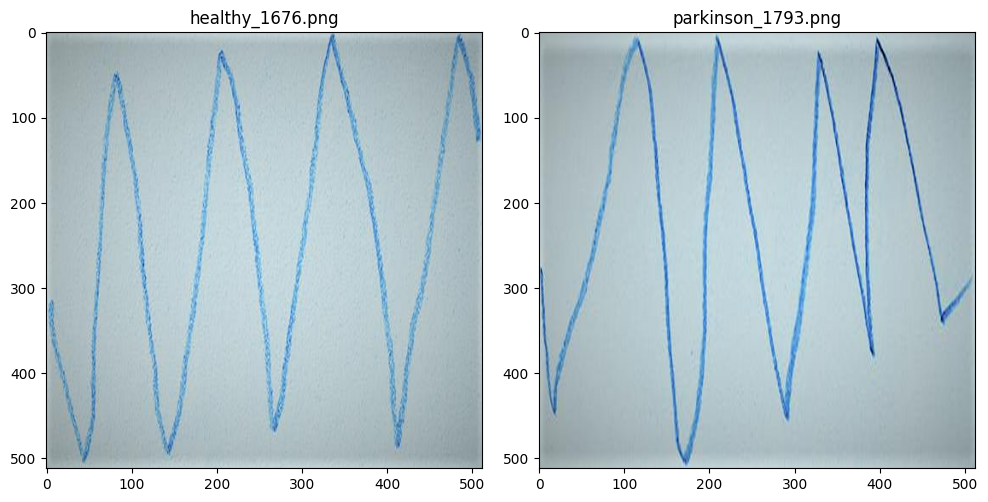

In [ ]:
# Definir a seed para o gerador de números aleatórios
random.seed(46)

# Gerar uma sequência de índices aleatórios
num_imagens_aleatorias = 2  # Número de imagens a serem selecionadas
indices_aleatorios = random.sample(range(len(imagens_ordenadas)), num_imagens_aleatorias)

# Selecionar as imagens usando os índices aleatórios
imagens_aleatorias = [imagens_ordenadas[i] for i in indices_aleatorios]

# Criar subplots para exibir as imagens lado a lado
fig, axes = plt.subplots(1, num_imagens_aleatorias, figsize=(10, 5))

# Imprimir as imagens nos subplots
for i, nome_imagem in enumerate(imagens_aleatorias):
    caminho_imagem = os.path.join(all_images_dir, nome_imagem)
    imagem = mpimg.imread(caminho_imagem)

    axes[i].imshow(imagem)
    axes[i].set_title(nome_imagem)

plt.tight_layout()
plt.show()

In [ ]:
dataset = pd.DataFrame()

## **Escolha das features extraídas**

Cada uma das features escolhidas contribui com um tipo diferente de informação sobre a forma, a textura ou a distribuição do objeto analisado.

---

### **1. Área (`area`)**

* **O que é:** Quantidade de pixels que compõem o objeto segmentado na imagem.
* **Por que é relevante:** A área pode indicar alterações estruturais em regiões específicas. Por exemplo, em imagens caligráficas de pacientes com Parkinson, alterações no controle motor podem impactar o tamanho das formas produzidas.
* **Tipo de informação:** **Morfologia / tamanho global**

---

### **2. Centroide X e Y (`centroide_x`, `centroide_y`)**

* **O que são:** Coordenadas do ponto central (centro de massa) do objeto.
* **Por que são relevantes:** O centroide pode mudar dependendo de **assimetria**, **postura**, ou **alterações estruturais**, especialmente úteis para entender deslocamentos e distribuição espacial de padrões anômalos.
* **Tipo de informação:** **Localização espacial / geometria**

---

### **3. Desvio padrão (`desvio_padrao`)**

* **O que é:** Medida da dispersão dos valores de intensidade (ou outro atributo, dependendo de como você calcula).
* **Por que é relevante:** Pode indicar **variabilidade de intensidade** (por exemplo, variações de pressão na escrita, ou diferenças de contraste em exames). Em doenças neurodegenerativas, os movimentos menos precisos podem gerar maior variabilidade.
* **Tipo de informação:** **Estatística de intensidade / dispersão**

---

### **4. Compacidade (`compactness`)**

* **O que é:** Medida que relaciona perímetro e área do objeto. Fórmula comum: $\text{Compacidade} = \frac{P^2}{4\pi A}$
* **Por que é relevante:** Objetos mais irregulares têm **alta compacidade**. Pode revelar instabilidade motora ou deformidades visuais, comuns em quadros como Parkinson.
* **Tipo de informação:** **Forma / regularidade**

---

### **5. Entropia (`entropia`)**

* **O que é:** Medida da aleatoriedade ou complexidade da distribuição de intensidades na imagem.
* **Por que é relevante:** Uma imagem com alta entropia pode ter **mais detalhes ou ruído**; já uma com baixa entropia pode ser mais uniforme. Mudanças na entropia são comuns em processos degenerativos ou patológicos.
* **Tipo de informação:** **Textura / complexidade**

---

### **6. HOG (Histogram of Oriented Gradients)**

* **O que é:** Descreve a distribuição de direções de gradientes em partes da imagem.
* **Por que é relevante:** Captura **padrões de bordas e orientações**, sendo muito usado em reconhecimento de formas. Ideal para captar **curvaturas e bordas suaves ou bruscas**, o que pode indicar anomalias motoras.
* **Tipo de informação:** **Textura / orientação / estrutura local**

---

### **7. LBP (Local Binary Pattern)**

* **O que é:** Técnica de descrição de textura baseada na comparação de cada pixel com seus vizinhos.
* **Por que é relevante:** Altamente eficaz para **capturar microtexturas**, variações finas e locais de padrão — ideal para distinguir **alterações sutis** associadas a distúrbios neuromusculares ou de escrita.
* **Tipo de informação:** **Textura local / microestrutura**

---

### Conclusão

As features foram escolhidas de forma a abranger diferentes dimensões da imagem: **geometria global (área, centroide, compactness)**, **estatísticas de intensidade (desvio padrão, entropia)** e **textura local (HOG e LBP)**. Essa diversidade garante que o modelo possa capturar desde **alterações grosseiras de forma** até **padrões sutis de textura**, ambos relevantes em contextos como o diagnóstico de Parkinson, onde tanto a motricidade fina quanto o traçado visual podem sofrer alterações significativas.


In [ ]:
pasta_imagens = pasta_origem_imagens
pasta_labels = pasta_origem_labels

for nome_imagem in imagens_ordenadas:
    caminho_imagem = os.path.join(all_images_dir, nome_imagem)

    # Obter o nome do arquivo de label correspondente
    nome_arquivo_label = os.path.splitext(nome_imagem)[0] + '.txt'
    caminho_label = os.path.join(all_labels_dir, nome_arquivo_label)

    # Ler a label do arquivo (assumindo que a primeira linha contém a label)
    with open(caminho_label, 'r') as f:
        label = int(f.readline().split()[0])

    # Extrair features e adicionar ao DataFrame
    features = extrair_features(caminho_imagem, label)
    dataset = pd.concat([dataset, pd.DataFrame([features])], ignore_index=True)

In [ ]:
dataset

,nome_imagem,label,area,centroide_x,centroide_y,perimetro_total,desvio_padrao,compactness,entropia,hog_0,...,lbp_16,lbp_17,lbp_18,lbp_19,lbp_20,lbp_21,lbp_22,lbp_23,lbp_24,lbp_25
0,healthy_1598.png,1,3756752.0,63,63,508.0,18.345328,0.068693,3.331900,0.277365,...,0.004395,0.007324,0.002563,0.002441,0.001831,0.002258,0.008057,0.049133,0.065979,0.661316
1,healthy_1599.png,1,3717855.0,62,63,508.0,32.254854,0.069412,3.577742,0.271882,...,0.005188,0.006897,0.002808,0.002258,0.002380,0.002686,0.010010,0.049133,0.064514,0.657104
2,healthy_1600.png,1,3747830.0,63,63,508.0,28.951977,0.068857,3.491593,0.281566,...,0.003845,0.008606,0.003845,0.001770,0.001770,0.003357,0.006287,0.050415,0.062256,0.659851
3,healthy_1601.png,1,3721727.0,62,63,508.0,31.432756,0.069340,3.507854,0.216055,...,0.005615,0.008240,0.002502,0.002197,0.001587,0.003235,0.007568,0.045532,0.063599,0.660522
4,healthy_1602.png,1,3728206.0,63,63,508.0,19.955548,0.069219,3.587170,0.274861,...,0.005066,0.006897,0.002808,0.003906,0.001953,0.003967,0.012573,0.046387,0.065735,0.645081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,parkinson_995.jpg,2,3524723.0,63,64,508.0,43.067058,0.073215,4.053718,0.046172,...,0.004822,0.008545,0.002991,0.003296,0.004028,0.004761,0.007324,0.035339,0.074768,0.622131
743,parkinson_996.jpg,2,3476316.0,62,63,508.0,50.851267,0.074235,3.887141,0.063299,...,0.005188,0.006836,0.003357,0.002625,0.003723,0.006531,0.012756,0.036194,0.074402,0.598022
744,parkinson_997.jpg,2,3490655.0,63,63,508.0,47.456687,0.073930,3.862846,0.060339,...,0.005371,0.006348,0.003174,0.003601,0.004517,0.006226,0.011902,0.037720,0.068054,0.612671
745,parkinson_998.jpg,2,3403226.0,62,63,508.0,53.443898,0.075829,4.018014,0.041716,...,0.004761,0.006165,0.003418,0.004089,0.004578,0.006409,0.010803,0.033813,0.071899,0.587219


In [ ]:
# Embaralhando o dataset com uma seed para reprodutibilidade
dataset = dataset.sample(frac=1, random_state=42)

# Resetando os índices do DataFrame
dataset = dataset.reset_index(drop=True)

dataset

,nome_imagem,label,area,centroide_x,centroide_y,perimetro_total,desvio_padrao,compactness,entropia,hog_0,...,lbp_16,lbp_17,lbp_18,lbp_19,lbp_20,lbp_21,lbp_22,lbp_23,lbp_24,lbp_25
0,healthy_806.png,0,3779949.0,63,63,508.0,17.914093,0.068272,3.273185,0.073146,...,0.003052,0.005554,0.002197,0.004333,0.002686,0.002686,0.007446,0.050598,0.075623,0.647949
1,healthy_857.jpg,0,3588350.0,63,63,508.0,55.120873,0.071917,3.704200,0.042630,...,0.005005,0.005981,0.003235,0.003052,0.004639,0.005676,0.012207,0.036072,0.071289,0.590271
2,healthy_1695.png,1,3089800.0,63,63,508.0,16.400519,0.083521,4.113482,0.251106,...,0.008667,0.011658,0.007568,0.009583,0.007141,0.008667,0.013245,0.033508,0.046631,0.607117
3,healthy_1746.png,1,3823530.0,63,63,508.0,19.421910,0.067494,3.494301,0.154952,...,0.003967,0.004456,0.003479,0.004211,0.002441,0.004150,0.014160,0.047607,0.065552,0.654358
4,parkinson_1085.png,2,3797633.0,63,63,508.0,20.175775,0.067954,3.311251,0.103113,...,0.004761,0.005066,0.002197,0.004395,0.002625,0.003052,0.009583,0.045410,0.075012,0.647522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,healthy_1669.png,1,3713759.0,63,63,508.0,23.837723,0.069489,3.472459,0.280631,...,0.005249,0.007812,0.002686,0.002991,0.001709,0.002991,0.008911,0.050049,0.067139,0.648499
743,healthy_1704.png,1,3771561.0,63,63,508.0,20.455813,0.068424,3.532463,0.117075,...,0.004578,0.007629,0.003174,0.003662,0.002747,0.004761,0.016602,0.044128,0.060425,0.634277
744,healthy_868.jpg,0,3963824.0,63,63,508.0,36.665095,0.065105,2.598035,0.012810,...,0.017395,0.040466,0.012146,0.012146,0.011414,0.012390,0.015137,0.021484,0.156067,0.389771
745,parkinson_1819.png,3,3834517.0,63,63,508.0,16.956938,0.067300,3.564547,0.160805,...,0.004272,0.006653,0.002991,0.004883,0.003662,0.003113,0.008606,0.046936,0.064453,0.658020


In [ ]:
# soma dos valores únicos das primeiras 9 colunas
dataset.iloc[:, :9].nunique()

,0
nome_imagem,747
label,4
area,689
centroide_x,3
centroide_y,3
perimetro_total,1
desvio_padrao,689
compactness,689
entropia,689


Pela análise da soma de valores únicos das colunas das features que escolhemos para tentar descrever a imagem, 2 já podem ser descartadas.
nome_imagem possui um valor único para cada linha
perimetro_total possui o mesmo valor para todas as linhas

In [ ]:
# dropando as colunas nome_imagem e perimetro_total
dataset.drop(['nome_imagem', 'perimetro_total'], axis=1, inplace=True)

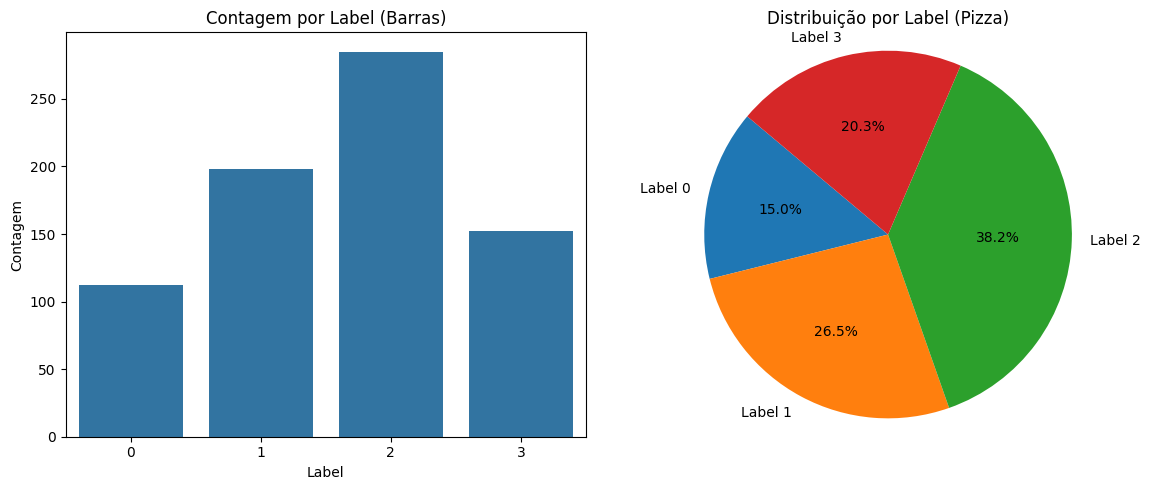

In [ ]:
# Contando os valores das labels
contagem_labels = dataset['label'].value_counts().sort_index()

# Labels legíveis para o gráfico de pizza
labels_pizza = [f'Label {label}' for label in contagem_labels.index]
sizes_pizza = contagem_labels.values

# Criando os subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # 1 linha, 2 colunas

# Gráfico de barras no primeiro subplot
sns.countplot(x='label', data=dataset, ax=axes[0])
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Contagem')
axes[0].set_title('Contagem por Label (Barras)')

# Gráfico de pizza no segundo subplot
axes[1].pie(sizes_pizza, labels=labels_pizza, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Distribuição por Label (Pizza)')
axes[1].axis('equal')

plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

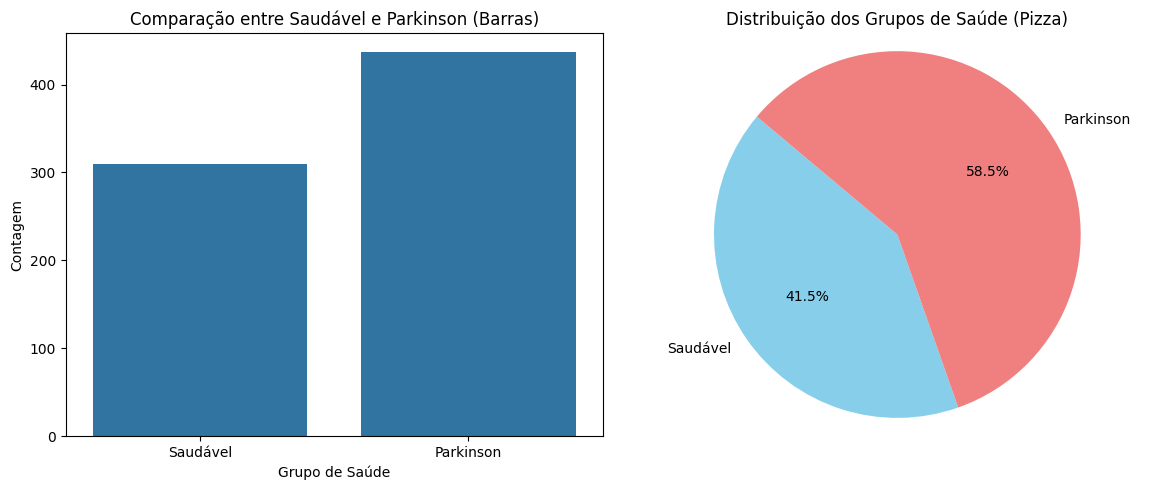

In [ ]:
# Criando coluna binária
dataset['grupo_saude'] = dataset['label'].apply(lambda x: 0 if x in [0, 1] else 1)

# Contando os valores dos grupos
contagem_grupos = dataset['grupo_saude'].value_counts()

# Criando os subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # 1 linha, 2 colunas

# Gráfico de barras no primeiro subplot
sns.countplot(x='grupo_saude', data=dataset, ax=axes[0])
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Saudável', 'Parkinson'])
axes[0].set_xlabel('Grupo de Saúde')
axes[0].set_ylabel('Contagem')
axes[0].set_title('Comparação entre Saudável e Parkinson (Barras)')

# Gráfico de pizza no segundo subplot
labels = ['Saudável', 'Parkinson']
sizes = [contagem_grupos[0], contagem_grupos[1]]
axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
axes[1].set_title('Distribuição dos Grupos de Saúde (Pizza)')
axes[1].axis('equal')  # Garante que o gráfico de pizza seja um círculo.

plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

## **Exploração sobre a diminuição da dimensionalidade do dataset**

In [ ]:
# Separando variáveis alvo
X = dataset.drop(columns=['label', 'grupo_saude'])
y_4classes = dataset['label']
y_binario = dataset['grupo_saude']

In [ ]:
# Criando cópias do dataset para testar desempenho dos modelos com diminuição da dimensionalidade
X_4classes_aux_mcorr = X.copy()
X_binario_aux_mcorr = X.copy()

In [ ]:
# Definindo dicionários de parâmetros fixos
fixed_params_rf = {
    'n_estimators': 418,
    'max_depth': 21,
    'min_samples_split': 7,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'class_weight': 'balanced',
    'random_state': 42,
    'n_jobs': 1
}

fixed_params_svm = {
    'C': 16,
    'gamma': 0.0028,
    'kernel': 'rbf',
    'class_weight': 'balanced',
}

fixed_params_xgb = {
    'n_estimators': 135,
    'max_depth': 11,
    'learning_rate': 0.056,
    'subsample': 0.69,
    'colsample_bytree': 0.64,
    'gamma': 0.05,
    'reg_alpha': 0.20,
    'reg_lambda': 5.75e-05,
    'random_state': 42,
    'n_jobs': 1,
    'objective': 'multi:softprob', # Para avaliação multiclasse
    'eval_metric': 'mlogloss'     # Para avaliação multiclasse
}

fixed_params_xgb_binario = {
    'n_estimators': 271,
    'max_depth': 4,
    'learning_rate': 0.052,
    'subsample': 0.55,
    'colsample_bytree': 0.58,
    'gamma': 0.58,
    'reg_alpha': 0.0016,
    'reg_lambda': 0.0039,
    'random_state': 42,
    'n_jobs': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': (len(y_binario) - y_binario.sum()) / y_binario.sum() if y_binario.sum() > 0 else 1
}


# Criando instâncias dos modelos com os parâmetros fixos

# Para avaliação Multiclasse
rf_model_fixed_4classes = RandomForestClassifier(**fixed_params_rf)
svm_model_fixed_4classes = SVC(**fixed_params_svm)
xgb_model_fixed_4classes = XGBClassifier(**fixed_params_xgb)


# Para avaliação Binária
rf_model_fixed_binario = RandomForestClassifier(**fixed_params_rf)
svm_model_fixed_binario = SVC(**fixed_params_svm)
xgb_model_fixed_binario = XGBClassifier(**fixed_params_xgb_binario)


# Populando os dicionários para a função de avaliação

# Dicionário para avaliação Multiclasse com parâmetros fixos
modelos_dict_fixed_4classes = {
    "Random Forest (Fixed)": rf_model_fixed_4classes,
    "SVM (Fixed)": svm_model_fixed_4classes,
    "XGBoost (Fixed)": xgb_model_fixed_4classes
}

# Dicionário para avaliação Binária com parâmetros fixos
modelos_dict_fixed_binario = {
    "Random Forest (Fixed)": rf_model_fixed_binario,
    "SVM (Fixed)": svm_model_fixed_binario,
    "XGBoost (Fixed)": xgb_model_fixed_binario
}


# Transforme os dicionários em listas para a nova função
modelos_list_4classes_fixed = [{'name': k, 'model_class': type(v), 'model_params': v.get_params()} for k, v in modelos_dict_fixed_4classes.items()]
modelos_list_binario_fixed = [{'name': k, 'model_class': type(v), 'model_params': v.get_params()} for k, v in modelos_dict_fixed_binario.items()]


print("### MULTICLASSE - AVALIAÇÃO COM PARÂMETROS FIXOS e CV ###")
# Avalie com PCA
avaliar_modelos_com_dim_reduction_cv(modelos_list_4classes_fixed, X_4classes_aux_mcorr, y_4classes, dim_reduction_method='pca', n_components=60)
# Avalie com SelectKBest
avaliar_modelos_com_dim_reduction_cv(modelos_list_4classes_fixed, X_4classes_aux_mcorr, y_4classes, dim_reduction_method='selectkbest', n_components=60)


print("\n### BINÁRIO - AVALIAÇÃO COM PARÂMETROS FIXOS e CV ###")
# Avalie com PCA
avaliar_modelos_com_dim_reduction_cv(modelos_list_binario_fixed, X_binario_aux_mcorr, y_binario, dim_reduction_method='pca', n_components=60)
# Avalie com SelectKBest
avaliar_modelos_com_dim_reduction_cv(modelos_list_binario_fixed, X_binario_aux_mcorr, y_binario, dim_reduction_method='selectkbest', n_components=60)

### MULTICLASSE - AVALIAÇÃO COM PARÂMETROS FIXOS e CV ###

=== Avaliação com PCA (60 componentes) e Cross-Validation ===

Modelo: Random Forest (Fixed)
 - CV Resultados: Accuracy = 0.7979 ± 0.0249, F1_macro = 0.7428 ± 0.0362

Modelo: SVM (Fixed)
 - CV Resultados: Accuracy = 0.7725 ± 0.0408, F1_macro = 0.7537 ± 0.0359

Modelo: XGBoost (Fixed)
 - CV Resultados: Accuracy = 0.7992 ± 0.0216, F1_macro = 0.7574 ± 0.0283

=== Avaliação com SELECTKBEST (60 componentes) e Cross-Validation ===

Modelo: Random Forest (Fixed)
 - CV Resultados: Accuracy = 0.7832 ± 0.0303, F1_macro = 0.7379 ± 0.0406

Modelo: SVM (Fixed)
 - CV Resultados: Accuracy = 0.7094 ± 0.0391, F1_macro = 0.6918 ± 0.0389

Modelo: XGBoost (Fixed)
 - CV Resultados: Accuracy = 0.7845 ± 0.0236, F1_macro = 0.7399 ± 0.0364

### BINÁRIO - AVALIAÇÃO COM PARÂMETROS FIXOS e CV ###

=== Avaliação com PCA (60 componentes) e Cross-Validation ===

Modelo: Random Forest (Fixed)
 - CV Resultados: Accuracy = 0.8006 ± 0.0218, F1_macro = 0.7852 ± 0

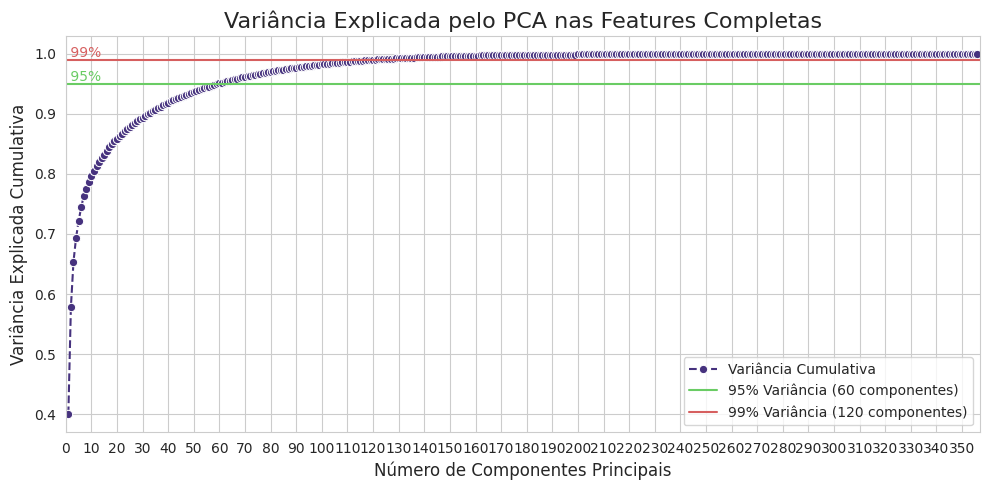

Número total de features/componentes possíveis: 356
Número de componentes para explicar 95% da variância: 60
Número de componentes para explicar 99% da variância: 120


In [ ]:
plot_pca_variance_explained(X, title="Variância Explicada pelo PCA nas Features Completas")

## **Conclusão**

A partir dos resultados obtidos, parece ser interessante testar a solução com PCA, dado que seu desempenho foi melhor que com o SelectKBest

# **Aprendizado de Máquina**

## **Escolha dos modelos**

Utilizamos os modelos **Random Forest, SVM e XGBoost** para classificar os dados extraídos das imagens. A tarefa de classificação foi realizada de duas maneiras: uma multiclasse, com as categorias 'Saudável 0', 'Saudável 1', 'Parkinson 2' e 'Parkinson 3', e outra binária, agrupando as classes apenas como 'Saudável' e 'Parkinson'. A diferença entre as classes 'Saudável 0' e 'Saudável 1', bem como entre 'Parkinson 2' e 'Parkinson 3', reside no tipo de imagem utilizada: espiral ou senoidal.

---

**Random Forest:**

* Modelo baseado em múltiplas árvores de decisão (ensemble), o que o torna robusto contra overfitting em muitos casos.
* Funciona bem mesmo quando as classes não são linearmente separáveis.
* Lida naturalmente com dados ruidosos e com variáveis correlacionadas.

---

**SVM (Support Vector Machine):**

* Ideal para problemas com fronteiras de decisão complexas.
* Busca encontrar o hiperplano que maximiza a margem entre as classes, sendo eficaz quando as diferenças entre os grupos são sutis.
* Funciona bem em espaços de alta dimensão, como o formado por descritores como HOG e LBP.

---

**XGBoost:**

* Algoritmo baseado em boosting, que constrói árvores de forma sequencial, corrigindo erros das anteriores.
* Costuma ter excelente desempenho em problemas de classificação tabular com volume moderado de dados.
* Possui mecanismos internos de regularização, que ajudam a evitar overfitting.
* É altamente eficiente em termos computacionais e possui várias opções de ajuste fino via hiperparâmetros.

## **Automação da escolha dos hiperparâmetros**

A escolha adequada de hiperparâmetros é essencial para o bom desempenho de modelos de aprendizado de máquina. No entanto, esse processo pode ser demorado e ineficiente quando feito manualmente ou mesmo por meio de abordagens tradicionais como grid search e random search, que testam combinações fixas sem considerar os resultados anteriores.

Para resolver isso, optamos por utilizar o Optuna, uma biblioteca de otimização de hiperparâmetros que implementa busca bayesiana com pruning automático de tentativas ruins. Os principais motivos dessa escolha incluem:
* Eficiência Computacional: o Optuna utiliza algoritmos de otimização sequencial, que priorizam regiões promissoras do espaço de busca, reduzindo drasticamente o número de avaliações necessárias.
* Flexibilidade: permite definir espaços de busca complexos, incluindo condicionais e ranges contínuos, adaptando-se facilmente às peculiaridades de cada modelo.
* Pruning de Execuções Ruins: durante a otimização, execuções com desempenho ruim podem ser interrompidas precocemente, economizando tempo computacional.
* Integração com Sklearn: o Optuna pode ser acoplado diretamente com pipelines do scikit-learn, tornando o processo simples e bem integrado ao restante do código.

Dessa forma, o uso do Optuna nos permite encontrar configurações de hiperparâmetros com melhor desempenho e menor custo computacional, resultando em modelos mais eficazes e robustos.

## **Random Forest**

### **Random Forest - Multiclasse**

#### **Sem redução de dimensionalidade**

##### Otimização de hiperparâmetros com Optuna


In [ ]:
# Random Forest multiclasse
pruner = SuccessiveHalvingPruner(min_resource=2, reduction_factor=3)
study_rf_4classes = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=pruner
)

study_rf_4classes.optimize(lambda trial: objective(trial, X, y_4classes, 'random_forest', usar_pca=False), n_trials=50, n_jobs=1)

parametros_rf_4classes = study_rf_4classes.best_params

print("RF melhores parâmetros:", study_rf_4classes.best_params)
print("RF melhor score:", study_rf_4classes.best_value)


[I 2025-05-21 18:22:11,285] A new study created in memory with name: no-name-7ae07825-47c7-4757-9b5b-36a9d3345833
[I 2025-05-21 18:22:20,376] Trial 0 finished with value: 0.7820740601124089 and parameters: {'n_estimators': 218, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7820740601124089.
[I 2025-05-21 18:22:22,269] Trial 1 finished with value: 0.7783969554477682 and parameters: {'n_estimators': 76, 'max_depth': 27, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.7820740601124089.
[I 2025-05-21 18:22:33,954] Trial 2 finished with value: 0.7960563416939614 and parameters: {'n_estimators': 425, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.7960563416939614.
[I 2025-05-21 18:22:37,671] Trial 3 pruned. 
[I 2025-05-21 18:22:43,631] Trial 4 pruned. 
[I 2025-05-21 18:22:51,124] Trial 5 pruned

RF melhores parâmetros: {'n_estimators': 410, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}
RF melhor score: 0.8015232026496527


##### Avaliação do modelo com kfold

Fold 1 - Accuracy: 0.7333 | Precision: 0.7161 | Recall: 0.7333 | F1: 0.7157
              precision    recall  f1-score   support

  Saudável 0       0.46      0.26      0.33        23
  Saudável 1       0.76      0.87      0.81        39
 Parkinson 2       0.75      0.88      0.81        57
 Parkinson 3       0.80      0.65      0.71        31

    accuracy                           0.73       150
   macro avg       0.69      0.66      0.67       150
weighted avg       0.72      0.73      0.72       150



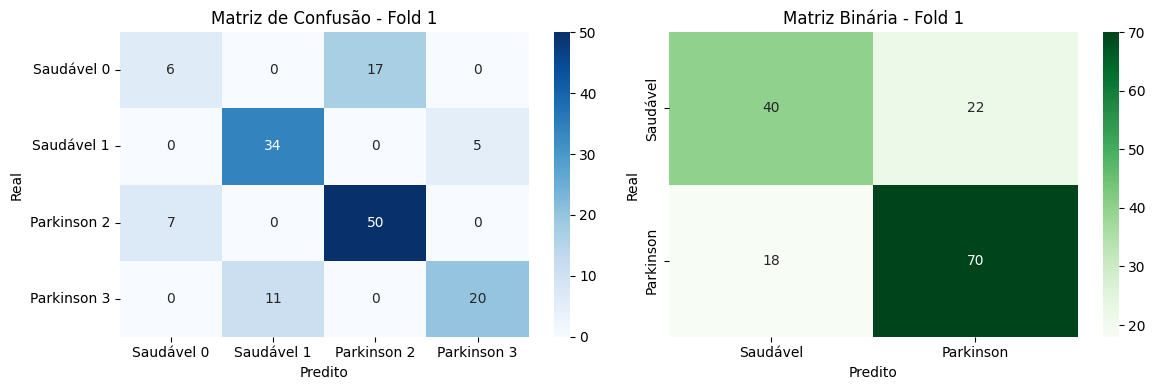

Fold 2 - Accuracy: 0.8200 | Precision: 0.8221 | Recall: 0.8200 | F1: 0.8117
              precision    recall  f1-score   support

  Saudável 0       0.86      0.52      0.65        23
  Saudável 1       0.79      0.87      0.83        39
 Parkinson 2       0.83      0.96      0.89        57
 Parkinson 3       0.81      0.71      0.76        31

    accuracy                           0.82       150
   macro avg       0.82      0.77      0.78       150
weighted avg       0.82      0.82      0.81       150



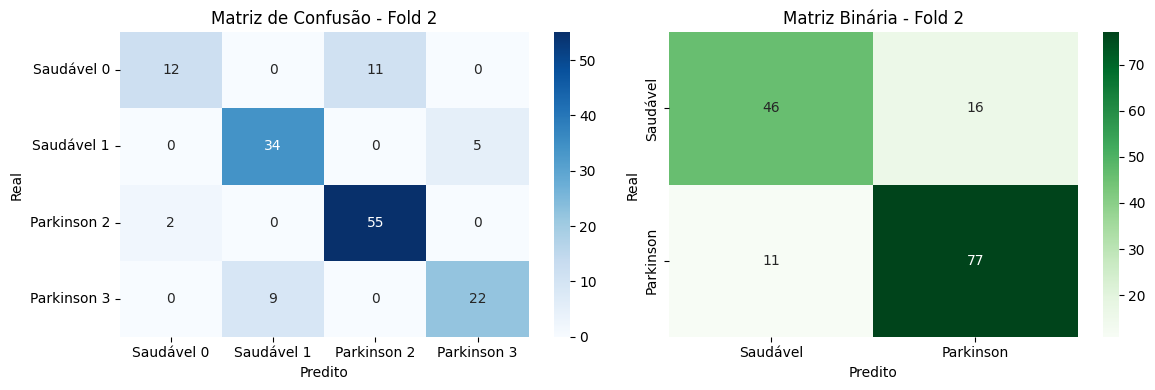

Fold 3 - Accuracy: 0.8255 | Precision: 0.8246 | Recall: 0.8255 | F1: 0.8166
              precision    recall  f1-score   support

  Saudável 0       0.77      0.45      0.57        22
  Saudável 1       0.89      0.82      0.86        40
 Parkinson 2       0.82      0.95      0.88        57
 Parkinson 3       0.79      0.87      0.83        30

    accuracy                           0.83       149
   macro avg       0.82      0.77      0.78       149
weighted avg       0.82      0.83      0.82       149



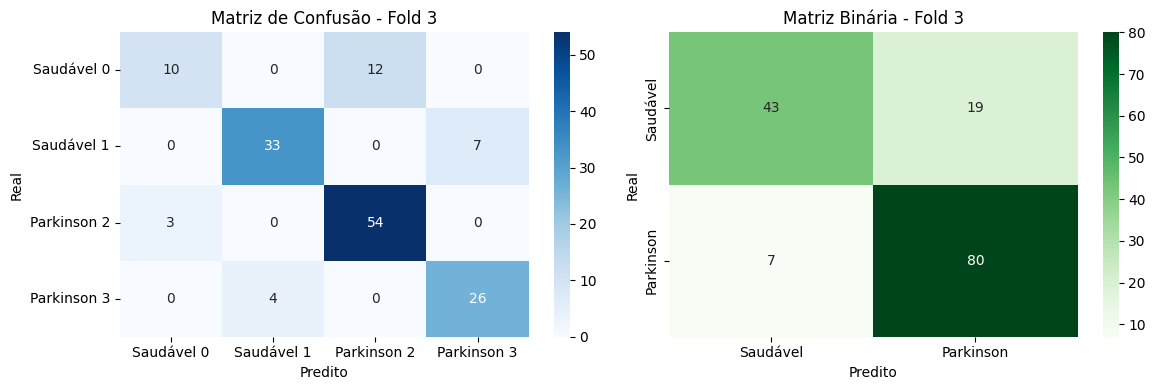

Fold 4 - Accuracy: 0.8389 | Precision: 0.8440 | Recall: 0.8389 | F1: 0.8372
              precision    recall  f1-score   support

  Saudável 0       0.83      0.68      0.75        22
  Saudável 1       0.88      0.75      0.81        40
 Parkinson 2       0.89      0.95      0.92        57
 Parkinson 3       0.72      0.87      0.79        30

    accuracy                           0.84       149
   macro avg       0.83      0.81      0.82       149
weighted avg       0.84      0.84      0.84       149



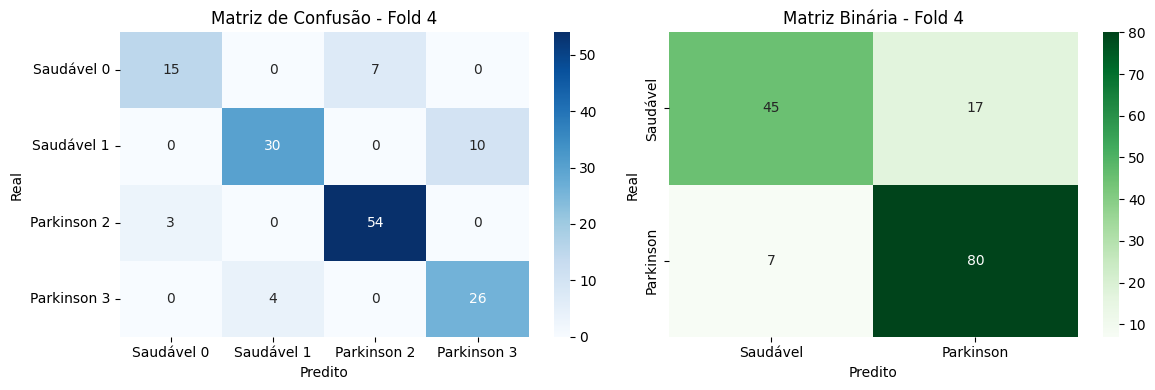

Fold 5 - Accuracy: 0.7987 | Precision: 0.7970 | Recall: 0.7987 | F1: 0.7917
              precision    recall  f1-score   support

  Saudável 0       0.71      0.55      0.62        22
  Saudável 1       0.77      0.90      0.83        40
 Parkinson 2       0.84      0.91      0.87        57
 Parkinson 3       0.83      0.63      0.72        30

    accuracy                           0.80       149
   macro avg       0.78      0.75      0.76       149
weighted avg       0.80      0.80      0.79       149



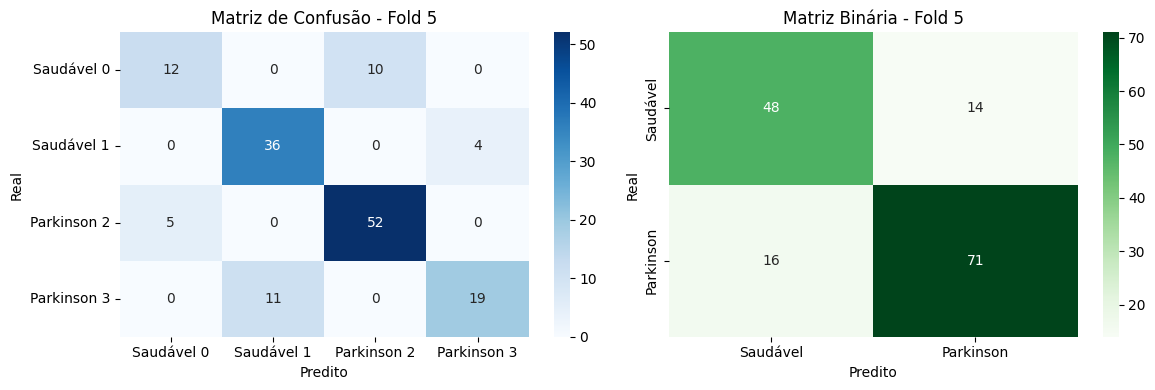


==== MÉDIAS GERAIS ====
Accuracy: 0.8033 ± 0.0373
Precision: 0.8008 ± 0.0449
Recall: 0.8033 ± 0.0373
F1 Score: 0.7946 ± 0.0420


In [ ]:
# avaliando modelo RF multiclasse
avaliar_modelo_kfold(X, y_4classes, RandomForestClassifier, parametros_rf_4classes, ['Saudável 0', 'Saudável 1', 'Parkinson 2', 'Parkinson 3'], binarizar_labels)

#### **Com redução de dimensionalidade - PCA**

##### Otimização de hiperparâmetros com Optuna

In [ ]:
# Random Forest multiclasse com PCA
pruner = SuccessiveHalvingPruner(min_resource=2, reduction_factor=3)
study_rf_4classes_pca = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=pruner
)

study_rf_4classes_pca.optimize(lambda trial: objective(trial, X, y_4classes, 'random_forest', usar_pca=True), n_trials=50, n_jobs=1)

parametros_rf_4classes_pca = study_rf_4classes_pca.best_params

print("RF melhores parâmetros:", study_rf_4classes_pca.best_params)
print("RF melhor score:", study_rf_4classes_pca.best_value)

[I 2025-05-21 15:13:13,515] A new study created in memory with name: no-name-63938e64-c213-4330-b5d8-331825f75534
[I 2025-05-21 15:13:17,417] Trial 0 finished with value: 0.7608558559003724 and parameters: {'n_estimators': 218, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'n_components': 11}. Best is trial 0 with value: 0.7608558559003724.
[I 2025-05-21 15:13:30,211] Trial 1 finished with value: 0.777597657220297 and parameters: {'n_estimators': 440, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'n_components': 29}. Best is trial 1 with value: 0.777597657220297.
[I 2025-05-21 15:13:36,370] Trial 2 finished with value: 0.7811437991939542 and parameters: {'n_estimators': 132, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'n_components': 75}. Best is trial 2 with value: 0.7811437991939542.
[I 2025-05-21 15:13:39,524] Trial 3 pruned. 
[I 2025-05-21 15:13:44,238] T

RF melhores parâmetros: {'n_estimators': 308, 'max_depth': 16, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 'log2', 'n_components': 25}
RF melhor score: 0.7916510094885536


##### Avaliação do modelo com kfold

Fold 1 - Accuracy: 0.7200 | Precision: 0.7036 | Recall: 0.7200 | F1: 0.6947
              precision    recall  f1-score   support

  Saudável 0       0.45      0.22      0.29        23
  Saudável 1       0.71      0.90      0.80        39
 Parkinson 2       0.74      0.89      0.81        57
 Parkinson 3       0.81      0.55      0.65        31

    accuracy                           0.72       150
   macro avg       0.68      0.64      0.64       150
weighted avg       0.70      0.72      0.69       150



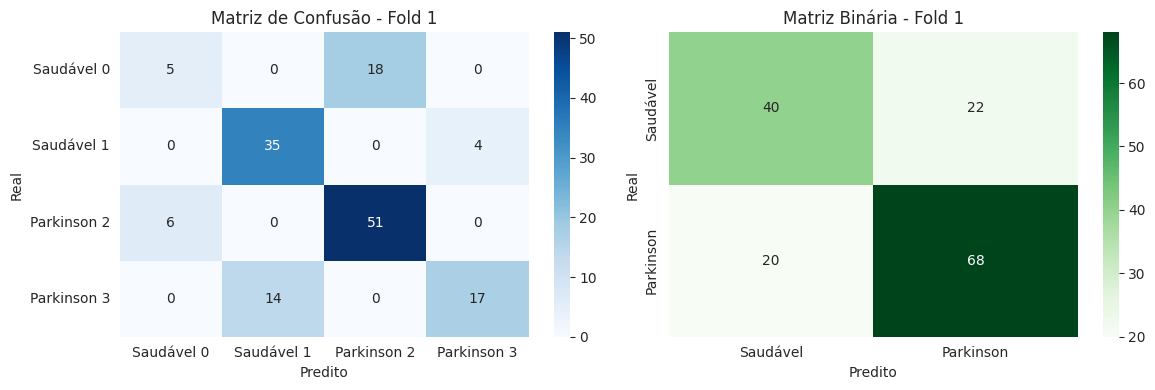

Fold 2 - Accuracy: 0.7867 | Precision: 0.7901 | Recall: 0.7867 | F1: 0.7710
              precision    recall  f1-score   support

  Saudável 0       0.82      0.39      0.53        23
  Saudável 1       0.76      0.87      0.81        39
 Parkinson 2       0.80      0.96      0.87        57
 Parkinson 3       0.80      0.65      0.71        31

    accuracy                           0.79       150
   macro avg       0.79      0.72      0.73       150
weighted avg       0.79      0.79      0.77       150



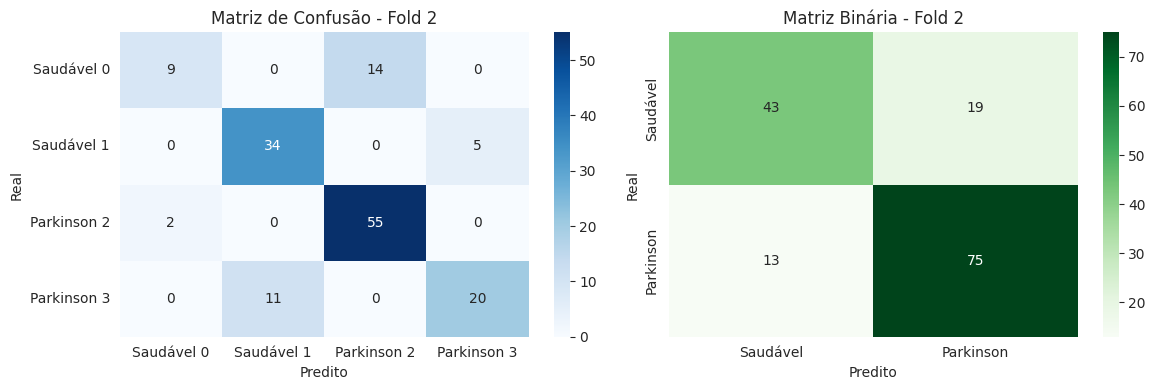

Fold 3 - Accuracy: 0.7852 | Precision: 0.7851 | Recall: 0.7852 | F1: 0.7679
              precision    recall  f1-score   support

  Saudável 0       0.78      0.32      0.45        22
  Saudável 1       0.82      0.82      0.82        40
 Parkinson 2       0.78      0.95      0.86        57
 Parkinson 3       0.74      0.77      0.75        30

    accuracy                           0.79       149
   macro avg       0.78      0.71      0.72       149
weighted avg       0.79      0.79      0.77       149



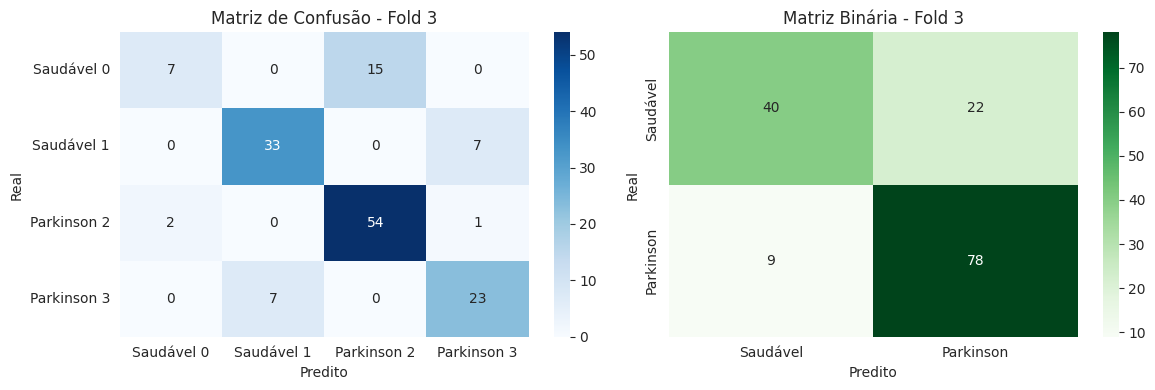

Fold 4 - Accuracy: 0.8389 | Precision: 0.8395 | Recall: 0.8389 | F1: 0.8361
              precision    recall  f1-score   support

  Saudável 0       0.82      0.64      0.72        22
  Saudável 1       0.86      0.80      0.83        40
 Parkinson 2       0.87      0.95      0.91        57
 Parkinson 3       0.76      0.83      0.79        30

    accuracy                           0.84       149
   macro avg       0.83      0.80      0.81       149
weighted avg       0.84      0.84      0.84       149



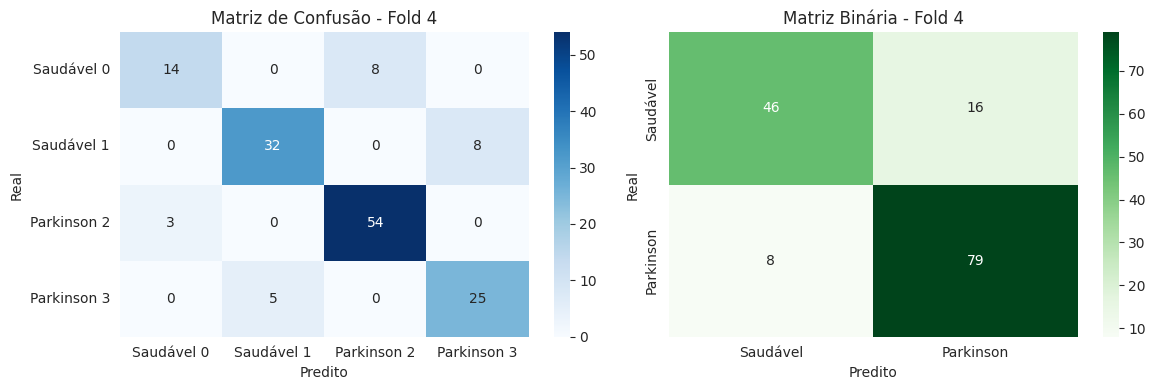

Fold 5 - Accuracy: 0.7450 | Precision: 0.7374 | Recall: 0.7450 | F1: 0.7284
              precision    recall  f1-score   support

  Saudável 0       0.62      0.36      0.46        22
  Saudável 1       0.71      0.88      0.79        40
 Parkinson 2       0.79      0.91      0.85        57
 Parkinson 3       0.76      0.53      0.63        30

    accuracy                           0.74       149
   macro avg       0.72      0.67      0.68       149
weighted avg       0.74      0.74      0.73       149



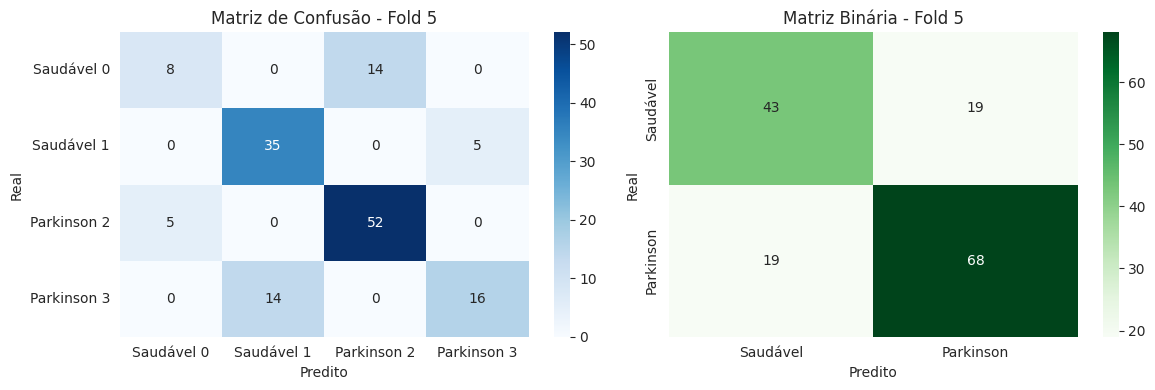


==== MÉDIAS GERAIS ====
Accuracy: 0.7752 ± 0.0406
Precision: 0.7711 ± 0.0468
Recall: 0.7752 ± 0.0406
F1 Score: 0.7596 ± 0.0474


In [ ]:
# avaliando modelo RF multiclasse com PCA
avaliar_modelo_kfold(X, y_4classes, RandomForestClassifier, parametros_rf_4classes_pca, ['Saudável 0', 'Saudável 1', 'Parkinson 2', 'Parkinson 3'], binarizar_labels)

### **Random Forest - Binário**

#### **Sem redução de dimensionalidade**

##### Otimização de hiperparâmetros com Optuna

In [ ]:
# Random Forest binário
pruner = SuccessiveHalvingPruner(min_resource=2, reduction_factor=3)
study_rf_binario = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=pruner
)

study_rf_binario.optimize(lambda trial: objective(trial, X, y_binario, 'random_forest', usar_pca=False), n_trials=50, n_jobs=1)

parametros_rf_binario = study_rf_binario.best_params

print("RF melhores parâmetros:", study_rf_binario.best_params)
print("RF melhor score:", study_rf_binario.best_value)

[I 2025-05-21 18:29:07,148] A new study created in memory with name: no-name-67646b56-a90e-457f-887b-84ad483030b1
[I 2025-05-21 18:29:16,464] Trial 0 finished with value: 0.7859499517141275 and parameters: {'n_estimators': 218, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7859499517141275.
[I 2025-05-21 18:29:17,488] Trial 1 pruned. 
[I 2025-05-21 18:29:29,110] Trial 2 finished with value: 0.8018348458587632 and parameters: {'n_estimators': 425, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.8018348458587632.
[I 2025-05-21 18:29:33,290] Trial 3 pruned. 
[I 2025-05-21 18:29:49,170] Trial 4 pruned. 
[I 2025-05-21 18:30:01,205] Trial 5 pruned. 
[I 2025-05-21 18:30:05,621] Trial 6 pruned. 
[I 2025-05-21 18:30:06,542] Trial 7 pruned. 
[I 2025-05-21 18:30:13,075] Trial 8 pruned. 
[I 2025-05-21 18:30:22,147] Trial 9 finished with value: 0.800179237

RF melhores parâmetros: {'n_estimators': 426, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}
RF melhor score: 0.8111185276119137


##### Avaliação do modelo com kfold

Fold 1 - Accuracy: 0.8133 | Precision: 0.8147 | Recall: 0.8133 | F1: 0.8102
              precision    recall  f1-score   support

    Saudável       0.83      0.69      0.75        62
   Parkinson       0.81      0.90      0.85        88

    accuracy                           0.81       150
   macro avg       0.82      0.80      0.80       150
weighted avg       0.81      0.81      0.81       150



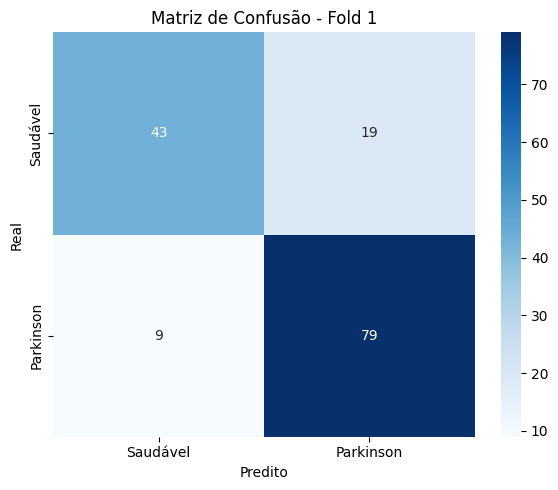

Fold 2 - Accuracy: 0.8067 | Precision: 0.8057 | Recall: 0.8067 | F1: 0.8053
              precision    recall  f1-score   support

    Saudável       0.79      0.73      0.76        62
   Parkinson       0.82      0.86      0.84        88

    accuracy                           0.81       150
   macro avg       0.80      0.79      0.80       150
weighted avg       0.81      0.81      0.81       150



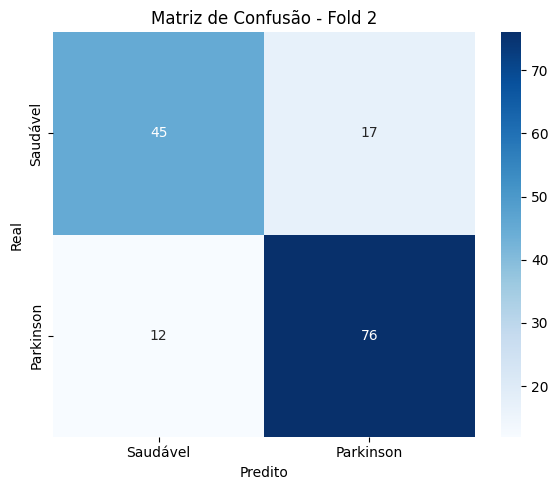

Fold 3 - Accuracy: 0.7852 | Precision: 0.7870 | Recall: 0.7852 | F1: 0.7807
              precision    recall  f1-score   support

    Saudável       0.80      0.65      0.71        62
   Parkinson       0.78      0.89      0.83        87

    accuracy                           0.79       149
   macro avg       0.79      0.77      0.77       149
weighted avg       0.79      0.79      0.78       149



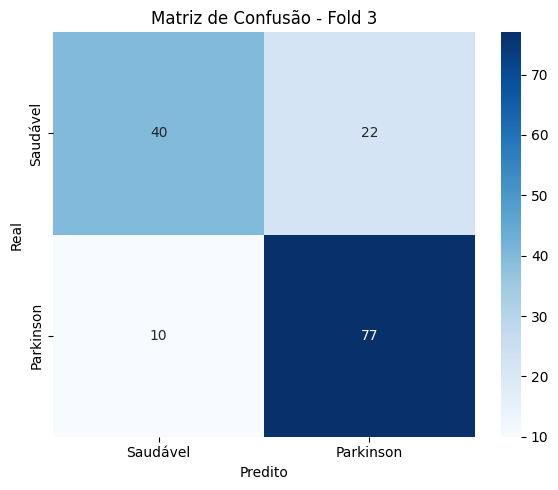

Fold 4 - Accuracy: 0.8255 | Precision: 0.8248 | Recall: 0.8255 | F1: 0.8246
              precision    recall  f1-score   support

    Saudável       0.81      0.76      0.78        62
   Parkinson       0.84      0.87      0.85        87

    accuracy                           0.83       149
   macro avg       0.82      0.82      0.82       149
weighted avg       0.82      0.83      0.82       149



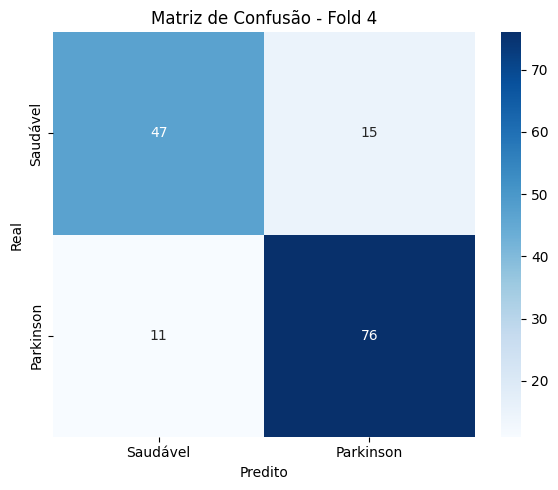

Fold 5 - Accuracy: 0.8054 | Precision: 0.8045 | Recall: 0.8054 | F1: 0.8046
              precision    recall  f1-score   support

    Saudável       0.78      0.74      0.76        62
   Parkinson       0.82      0.85      0.84        87

    accuracy                           0.81       149
   macro avg       0.80      0.80      0.80       149
weighted avg       0.80      0.81      0.80       149



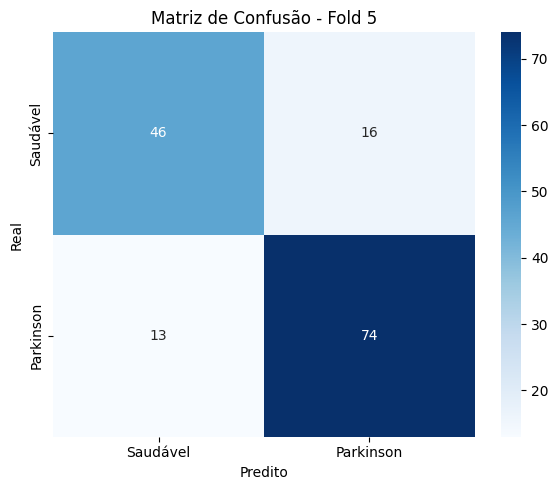


==== MÉDIAS GERAIS ====
Accuracy: 0.8072 ± 0.0131
Precision: 0.8074 ± 0.0125
Recall: 0.8072 ± 0.0131
F1 Score: 0.8051 ± 0.0142


In [ ]:
# avaliando modelo RF binário
avaliar_modelo_kfold(X, y_binario, RandomForestClassifier, parametros_rf_binario, ['Saudável', 'Parkinson'], binarizar_labels)

#### **Com redução de dimensionalidade - PCA**

##### Otimização de hiperparâmetros com Optuna

In [ ]:
# Random Forest binário com PCA
pruner = SuccessiveHalvingPruner(min_resource=2, reduction_factor=3)
study_rf_binario_pca = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=pruner
)

study_rf_binario_pca.optimize(lambda trial: objective(trial, X, y_binario, 'random_forest', usar_pca=True), n_trials=50, n_jobs=1)

parametros_rf_binario_pca = study_rf_binario_pca.best_params

print("RF melhores parâmetros:", study_rf_binario_pca.best_params)
print("RF melhor score:", study_rf_binario_pca.best_value)

[I 2025-05-21 17:26:38,922] A new study created in memory with name: no-name-9403f2ae-7712-4a95-9d39-e4e4422d5c61
[I 2025-05-21 17:26:45,594] Trial 0 finished with value: 0.7770643830620635 and parameters: {'n_estimators': 218, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'n_components': 11}. Best is trial 0 with value: 0.7770643830620635.
[I 2025-05-21 17:27:02,574] Trial 1 finished with value: 0.8055243292915593 and parameters: {'n_estimators': 440, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'n_components': 29}. Best is trial 1 with value: 0.8055243292915593.
[I 2025-05-21 17:27:05,633] Trial 2 pruned. 
[I 2025-05-21 17:27:08,593] Trial 3 pruned. 
[I 2025-05-21 17:27:13,863] Trial 4 pruned. 
[I 2025-05-21 17:27:25,237] Trial 5 finished with value: 0.8008424856627384 and parameters: {'n_estimators': 414, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'n_co

RF melhores parâmetros: {'n_estimators': 393, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'n_components': 78}
RF melhor score: 0.8070107441803144


##### Avaliação do modelo com kfold

Fold 1 - Accuracy: 0.8133 | Precision: 0.8147 | Recall: 0.8133 | F1: 0.8102
              precision    recall  f1-score   support

    Saudável       0.83      0.69      0.75        62
   Parkinson       0.81      0.90      0.85        88

    accuracy                           0.81       150
   macro avg       0.82      0.80      0.80       150
weighted avg       0.81      0.81      0.81       150



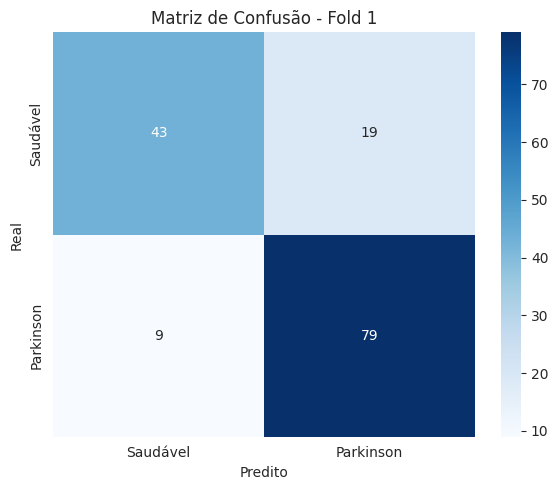

Fold 2 - Accuracy: 0.8067 | Precision: 0.8063 | Recall: 0.8067 | F1: 0.8064
              precision    recall  f1-score   support

    Saudável       0.77      0.76      0.76        62
   Parkinson       0.83      0.84      0.84        88

    accuracy                           0.81       150
   macro avg       0.80      0.80      0.80       150
weighted avg       0.81      0.81      0.81       150



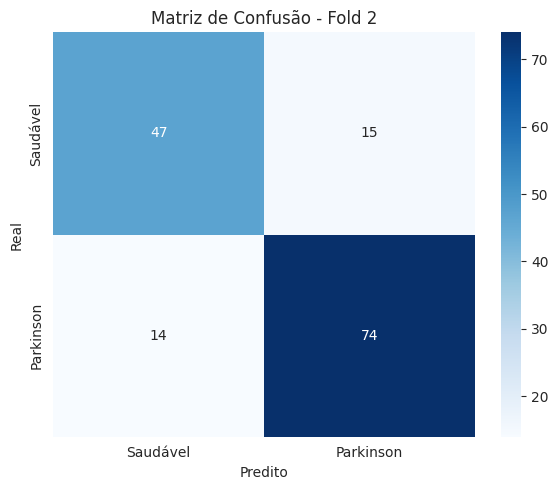

Fold 3 - Accuracy: 0.7450 | Precision: 0.7430 | Recall: 0.7450 | F1: 0.7427
              precision    recall  f1-score   support

    Saudável       0.71      0.65      0.68        62
   Parkinson       0.76      0.82      0.79        87

    accuracy                           0.74       149
   macro avg       0.74      0.73      0.73       149
weighted avg       0.74      0.74      0.74       149



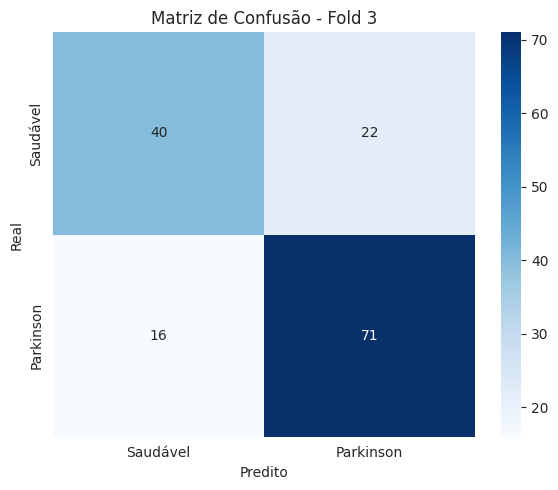

Fold 4 - Accuracy: 0.8188 | Precision: 0.8182 | Recall: 0.8188 | F1: 0.8175
              precision    recall  f1-score   support

    Saudável       0.81      0.74      0.77        62
   Parkinson       0.83      0.87      0.85        87

    accuracy                           0.82       149
   macro avg       0.82      0.81      0.81       149
weighted avg       0.82      0.82      0.82       149



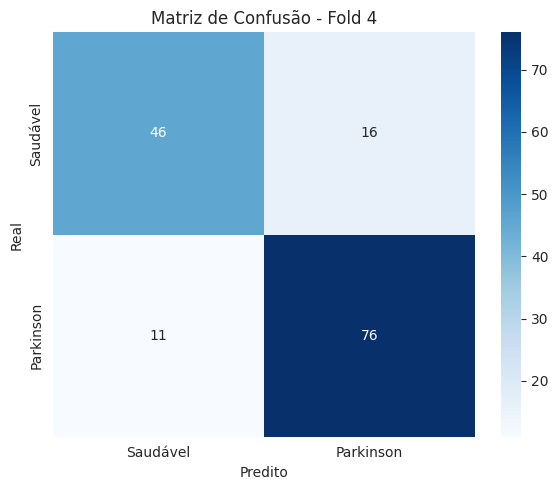

Fold 5 - Accuracy: 0.7919 | Precision: 0.7909 | Recall: 0.7919 | F1: 0.7905
              precision    recall  f1-score   support

    Saudável       0.77      0.71      0.74        62
   Parkinson       0.80      0.85      0.83        87

    accuracy                           0.79       149
   macro avg       0.79      0.78      0.78       149
weighted avg       0.79      0.79      0.79       149



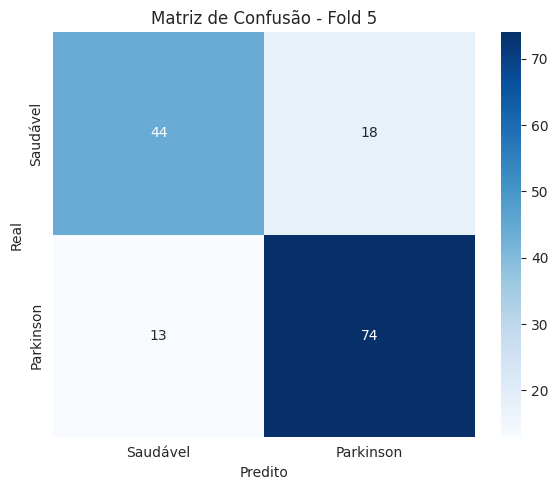


==== MÉDIAS GERAIS ====
Accuracy: 0.7951 ± 0.0266
Precision: 0.7946 ± 0.0275
Recall: 0.7951 ± 0.0266
F1 Score: 0.7935 ± 0.0269


In [ ]:
# avaliando modelo RF binário
avaliar_modelo_kfold(X, y_binario, RandomForestClassifier, parametros_rf_binario_pca, ['Saudável', 'Parkinson'], binarizar_labels)

### **Resultados e Conclusão Random Forest**

| Tipo de Classificação         | Redução de Dimensionalidade | Acurácia Média | F1-score Médio |
| ----------------------------- | --------------------------- | -------------- | -------------- |
| **Random Forest Multiclasse** | Não                         | 0.8033 ± 0.0373    | 0.7946 ± 0.0420    |
|                               | Sim                         | 0.7752 ± 0.0406    | 0.7596 ± 0.0474    |
|                               | **Impacto da Redução**      | **- 0.0281**     | **- 0.035**     |
| **Random Forest Binário**     | Não                         | 0.8072 ± 0.0131    | 0.8051 ± 0.0142    |
|                               | Sim                         | 0.7951 ± 0.0266    | 0.7935 ± 0.0269    |
|                               | **Impacto da Redução**      | **- 0.0121**     | **- 0.0116**     |

Para o modelo Random Forest, a aplicação de redução de dimensionalidade com PCA resultou em uma leve queda de desempenho em ambos os cenários. No caso multiclasse, a acurácia média reduziu-se em 0.0281 e o F1-score em 0.035. Já na classificação binária, o impacto foi menor, com reduções de 0.0121 na acurácia e 0.0116 no F1-score. Esses resultados sugerem que o Random Forest se beneficia mais de trabalhar com o conjunto completo de atributos, possivelmente por sua capacidade de selecionar automaticamente as variáveis mais relevantes.

## **SVM**

### **SVM - Multiclasse**

#### **Sem redução de dimensionalidade**

##### Otimização de hiperparâmetros com Optuna

In [ ]:
# SVM
pruner = SuccessiveHalvingPruner(min_resource=2, reduction_factor=3)
study_svm_4classes = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=pruner)

study_svm_4classes.optimize(lambda trial: objective(trial, X, y_4classes, 'svm', usar_pca=False), n_trials=50, n_jobs=1)

parametros_svm_4classes = study_svm_4classes.best_params

print("SVM melhores parâmetros:", study_svm_4classes.best_params)
print("SVM melhor score:", study_svm_4classes.best_value)

[I 2025-05-21 18:36:43,910] A new study created in memory with name: no-name-fdfa5c4d-8567-49f3-8c9e-f5ecbe226fe4
[I 2025-05-21 18:36:44,539] Trial 0 finished with value: 0.2171143003476197 and parameters: {'C': 0.05753773794117188, 'gamma': 0.008627358286640185}. Best is trial 0 with value: 0.2171143003476197.
[I 2025-05-21 18:36:44,933] Trial 1 finished with value: 0.7909223019193375 and parameters: {'C': 2.751804496272085, 'gamma': 0.0030049873591901574}. Best is trial 1 with value: 0.7909223019193375.
[I 2025-05-21 18:36:45,335] Trial 2 pruned. 
[I 2025-05-21 18:36:45,745] Trial 3 pruned. 
[I 2025-05-21 18:36:46,005] Trial 4 pruned. 
[I 2025-05-21 18:36:46,605] Trial 5 pruned. 
[I 2025-05-21 18:36:46,809] Trial 6 pruned. 
[I 2025-05-21 18:36:47,203] Trial 7 pruned. 
[I 2025-05-21 18:36:47,588] Trial 8 pruned. 
[I 2025-05-21 18:36:47,877] Trial 9 pruned. 
[I 2025-05-21 18:36:48,268] Trial 10 finished with value: 0.7972525523743066 and parameters: {'C': 36.25536780922698, 'gamma': 0.

SVM melhores parâmetros: {'C': 29.790739750944727, 'gamma': 0.0018155201604055527}
SVM melhor score: 0.8018187551076462


##### Avaliação do modelo com kfold

Fold 1 - Accuracy: 0.8000 | Precision: 0.7933 | Recall: 0.8000 | F1: 0.7953
              precision    recall  f1-score   support

  Saudável 0       0.53      0.43      0.48        23
  Saudável 1       0.88      0.92      0.90        39
 Parkinson 2       0.79      0.84      0.81        57
 Parkinson 3       0.90      0.84      0.87        31

    accuracy                           0.80       150
   macro avg       0.77      0.76      0.76       150
weighted avg       0.79      0.80      0.80       150



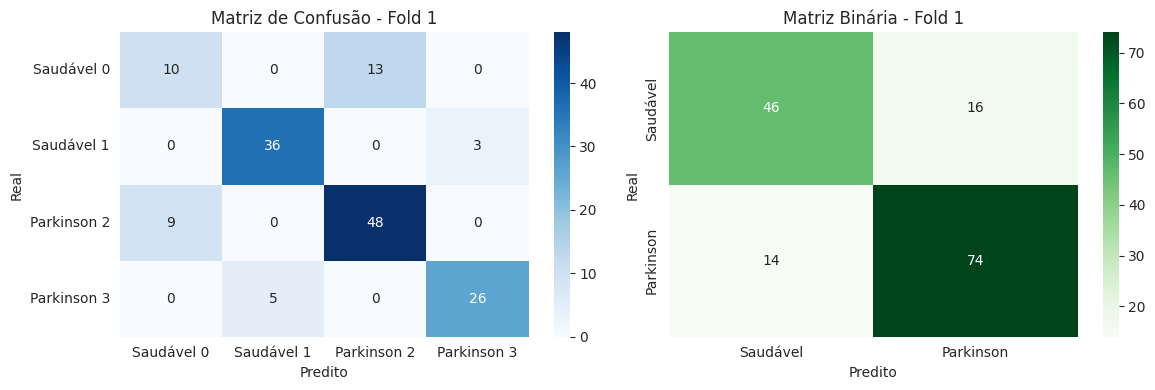

Fold 2 - Accuracy: 0.7667 | Precision: 0.7643 | Recall: 0.7667 | F1: 0.7651
              precision    recall  f1-score   support

  Saudável 0       0.62      0.57      0.59        23
  Saudável 1       0.79      0.77      0.78        39
 Parkinson 2       0.83      0.86      0.84        57
 Parkinson 3       0.72      0.74      0.73        31

    accuracy                           0.77       150
   macro avg       0.74      0.73      0.74       150
weighted avg       0.76      0.77      0.77       150



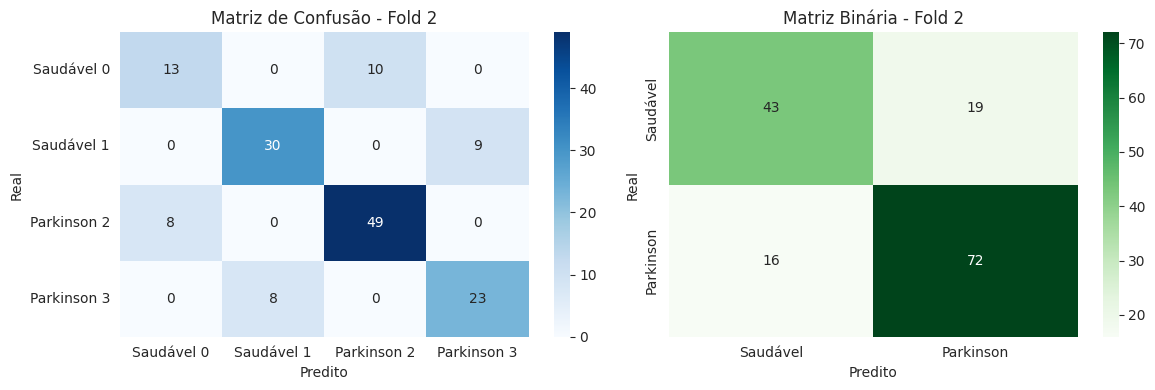

Fold 3 - Accuracy: 0.7785 | Precision: 0.7790 | Recall: 0.7785 | F1: 0.7787
              precision    recall  f1-score   support

  Saudável 0       0.50      0.50      0.50        22
  Saudável 1       0.87      0.85      0.86        40
 Parkinson 2       0.81      0.81      0.81        57
 Parkinson 3       0.81      0.83      0.82        30

    accuracy                           0.78       149
   macro avg       0.75      0.75      0.75       149
weighted avg       0.78      0.78      0.78       149



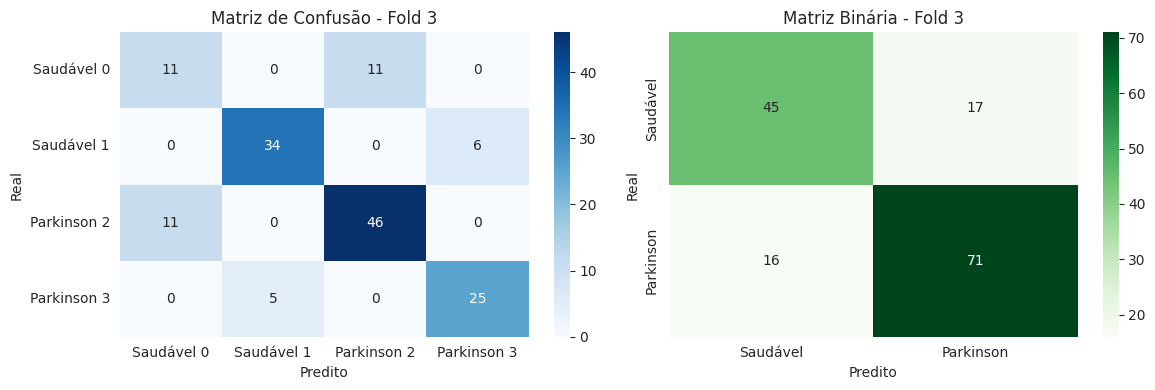

Fold 4 - Accuracy: 0.8188 | Precision: 0.8352 | Recall: 0.8188 | F1: 0.8223
              precision    recall  f1-score   support

  Saudável 0       0.59      0.73      0.65        22
  Saudável 1       0.94      0.80      0.86        40
 Parkinson 2       0.88      0.81      0.84        57
 Parkinson 3       0.78      0.93      0.85        30

    accuracy                           0.82       149
   macro avg       0.80      0.82      0.80       149
weighted avg       0.84      0.82      0.82       149



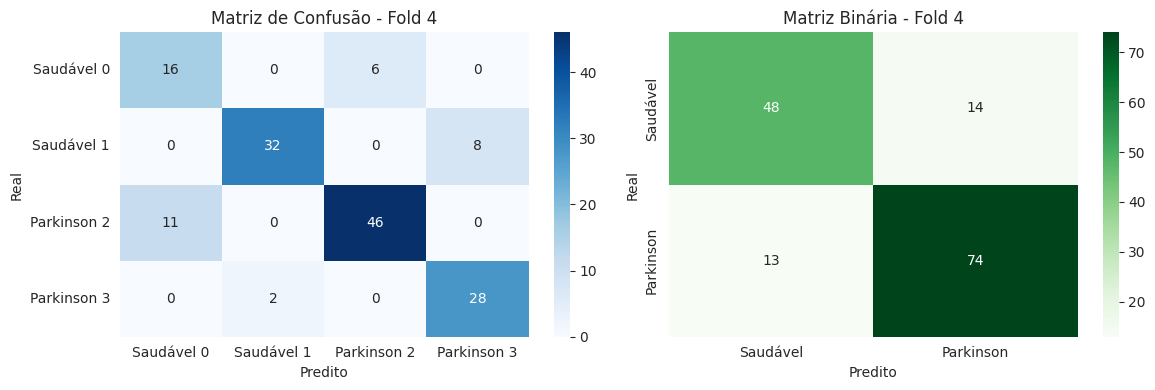

Fold 5 - Accuracy: 0.8188 | Precision: 0.8173 | Recall: 0.8188 | F1: 0.8107
              precision    recall  f1-score   support

  Saudável 0       0.62      0.45      0.53        22
  Saudável 1       0.83      0.97      0.90        40
 Parkinson 2       0.81      0.89      0.85        57
 Parkinson 3       0.96      0.73      0.83        30

    accuracy                           0.82       149
   macro avg       0.81      0.76      0.78       149
weighted avg       0.82      0.82      0.81       149



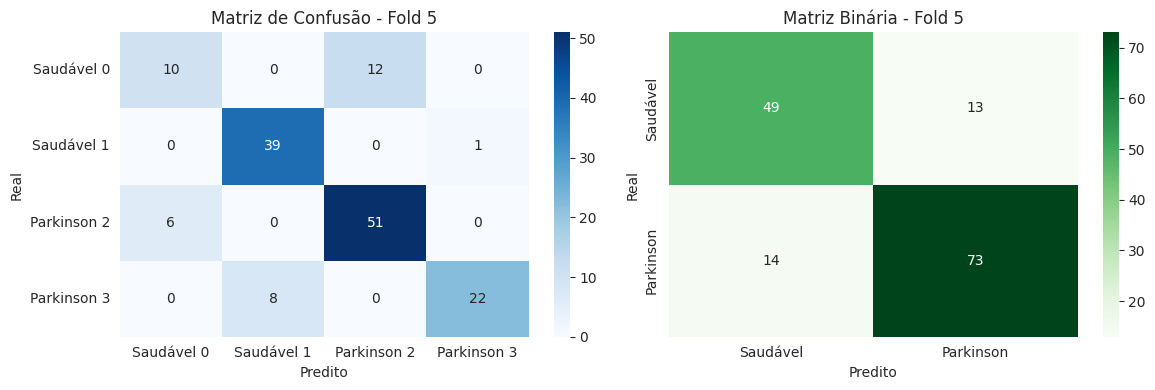


==== MÉDIAS GERAIS ====
Accuracy: 0.7966 ± 0.0211
Precision: 0.7978 ± 0.0256
Recall: 0.7966 ± 0.0211
F1 Score: 0.7944 ± 0.0207


In [ ]:
# avaliando modelo SVM
avaliar_modelo_kfold(X, y_4classes, SVC, parametros_svm_4classes, ['Saudável 0', 'Saudável 1', 'Parkinson 2', 'Parkinson 3'], binarizar_labels)

#### **Com redução de dimensionalidade - PCA**

##### Otimização de hiperparâmetros com Optuna

In [ ]:
# SVM
pruner = SuccessiveHalvingPruner(min_resource=2, reduction_factor=3)
study_svm_4classes_pca = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=pruner)

study_svm_4classes_pca.optimize(lambda trial: objective(trial, X, y_4classes, 'svm', usar_pca=True), n_trials=50, n_jobs=1)

parametros_svm_4classes_pca = study_svm_4classes_pca.best_params

print("SVM melhores parâmetros:", study_svm_4classes_pca.best_params)
print("SVM melhor score:", study_svm_4classes_pca.best_value)

[I 2025-05-21 16:23:24,148] A new study created in memory with name: no-name-1fdb9982-4482-4dbb-ba79-09096bc1f810
[I 2025-05-21 16:23:26,743] Trial 0 finished with value: 0.2829738712989822 and parameters: {'C': 0.05753773794117188, 'gamma': 0.008627358286640185, 'n_components': 89}. Best is trial 0 with value: 0.2829738712989822.
[I 2025-05-21 16:23:28,013] Trial 1 finished with value: 0.7062423252005152 and parameters: {'C': 0.6502468545951017, 'gamma': 0.0007979118876474872, 'n_components': 23}. Best is trial 1 with value: 0.7062423252005152.
[I 2025-05-21 16:23:29,576] Trial 2 pruned. 
[I 2025-05-21 16:23:33,413] Trial 3 finished with value: 0.7638017964735326 and parameters: {'C': 2.124280213720889, 'gamma': 0.0005318033256270141, 'n_components': 117}. Best is trial 3 with value: 0.7638017964735326.
[I 2025-05-21 16:23:36,177] Trial 4 finished with value: 0.7594417602586447 and parameters: {'C': 8.158738235092015, 'gamma': 0.00094456001380947, 'n_components': 26}. Best is trial 3 

SVM melhores parâmetros: {'C': 6.620467595674612, 'gamma': 0.009982674889249562, 'n_components': 55}
SVM melhor score: 0.7990696319097664


##### Avaliação do modelo com kfold

Fold 1 - Accuracy: 0.7800 | Precision: 0.7712 | Recall: 0.7800 | F1: 0.7671
              precision    recall  f1-score   support

  Saudável 0       0.62      0.35      0.44        23
  Saudável 1       0.86      0.79      0.83        39
 Parkinson 2       0.78      0.91      0.84        57
 Parkinson 3       0.76      0.84      0.80        31

    accuracy                           0.78       150
   macro avg       0.75      0.72      0.73       150
weighted avg       0.77      0.78      0.77       150



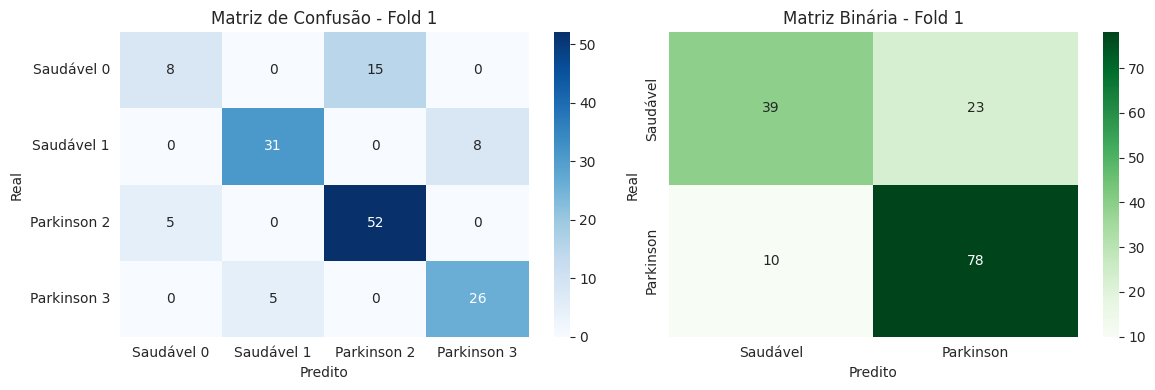

Fold 2 - Accuracy: 0.8133 | Precision: 0.8108 | Recall: 0.8133 | F1: 0.8112
              precision    recall  f1-score   support

  Saudável 0       0.75      0.65      0.70        23
  Saudável 1       0.80      0.82      0.81        39
 Parkinson 2       0.87      0.91      0.89        57
 Parkinson 3       0.77      0.74      0.75        31

    accuracy                           0.81       150
   macro avg       0.80      0.78      0.79       150
weighted avg       0.81      0.81      0.81       150



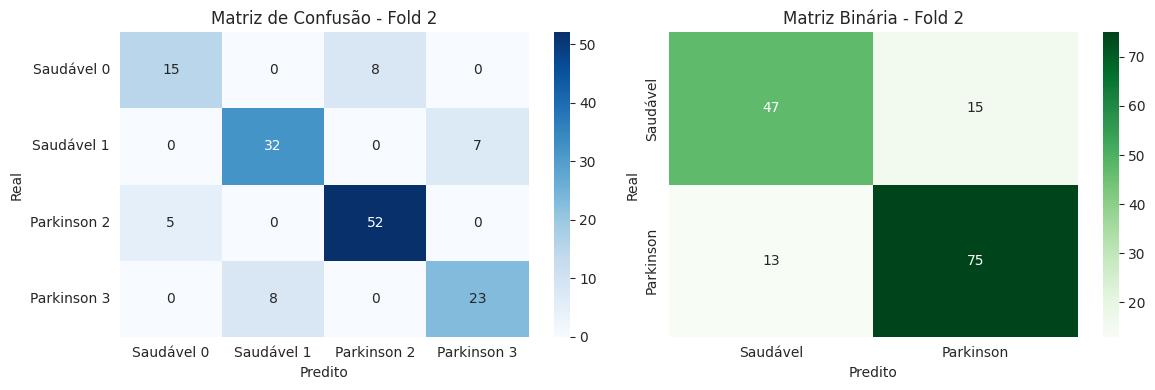

Fold 3 - Accuracy: 0.7919 | Precision: 0.7851 | Recall: 0.7919 | F1: 0.7873
              precision    recall  f1-score   support

  Saudável 0       0.56      0.45      0.50        22
  Saudável 1       0.85      0.88      0.86        40
 Parkinson 2       0.80      0.86      0.83        57
 Parkinson 3       0.83      0.80      0.81        30

    accuracy                           0.79       149
   macro avg       0.76      0.75      0.75       149
weighted avg       0.79      0.79      0.79       149



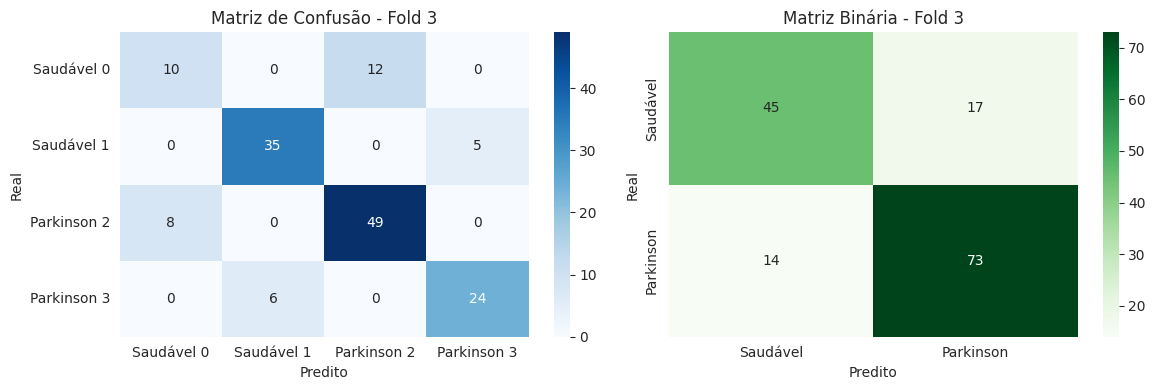

Fold 4 - Accuracy: 0.7785 | Precision: 0.7994 | Recall: 0.7785 | F1: 0.7798
              precision    recall  f1-score   support

  Saudável 0       0.48      0.50      0.49        22
  Saudável 1       1.00      0.75      0.86        40
 Parkinson 2       0.82      0.79      0.80        57
 Parkinson 3       0.73      1.00      0.85        30

    accuracy                           0.78       149
   macro avg       0.76      0.76      0.75       149
weighted avg       0.80      0.78      0.78       149



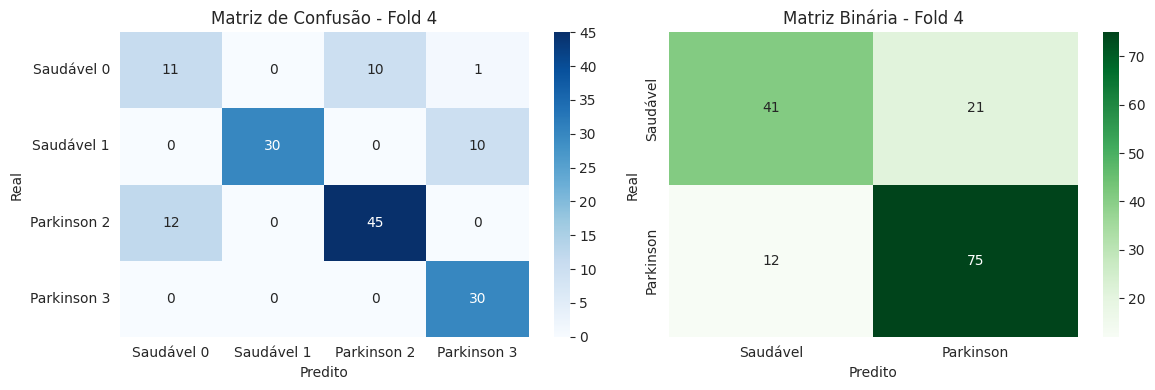

Fold 5 - Accuracy: 0.7987 | Precision: 0.7960 | Recall: 0.7987 | F1: 0.7859
              precision    recall  f1-score   support

  Saudável 0       0.77      0.45      0.57        22
  Saudável 1       0.76      0.97      0.86        40
 Parkinson 2       0.85      0.91      0.88        57
 Parkinson 3       0.75      0.60      0.67        30

    accuracy                           0.80       149
   macro avg       0.78      0.74      0.74       149
weighted avg       0.80      0.80      0.79       149



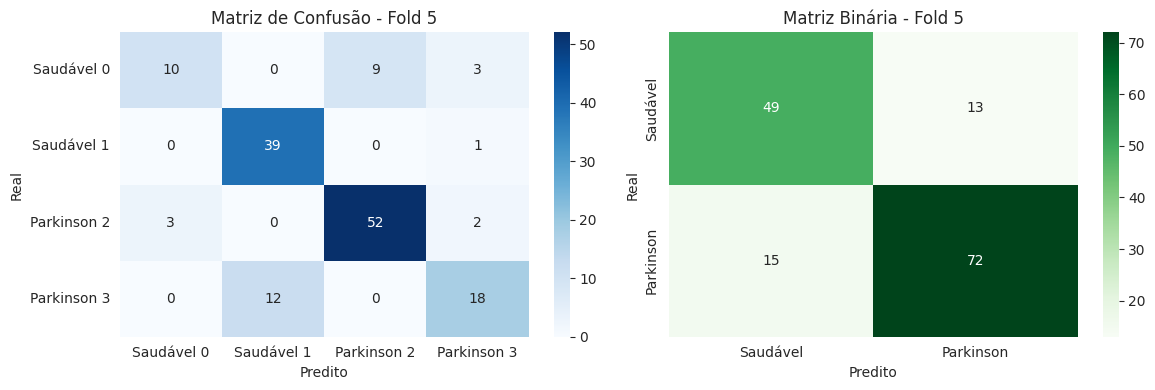


==== MÉDIAS GERAIS ====
Accuracy: 0.7925 ± 0.0128
Precision: 0.7925 ± 0.0134
Recall: 0.7925 ± 0.0128
F1 Score: 0.7863 ± 0.0144


In [ ]:
# avaliando modelo SVM Multiclasse - PCA
avaliar_modelo_kfold(
    X,
    y_4classes,
    SVC,
    parametros_svm_4classes_pca,
    ['Saudável 0', 'Saudável 1', 'Parkinson 2', 'Parkinson 3'],
    binarizar_labels
)

### **SVM - Binário**

#### **Sem redução de dimensionalidade**

##### Otimização de hiperparâmetros com Optuna


In [ ]:
# SVM
pruner = SuccessiveHalvingPruner(min_resource=2, reduction_factor=3)
study_svm_binario = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=pruner)

study_svm_binario.optimize(lambda trial: objective(trial, X, y_binario, 'svm'), n_trials=100, n_jobs=1)

parametros_svm_binario = study_svm_binario.best_params

print("SVM melhores parâmetros:", study_svm_binario.best_params)
print("SVM melhor score:", study_svm_binario.best_value)

[I 2025-05-21 18:37:04,265] A new study created in memory with name: no-name-cf41135c-05e6-448b-9b55-1b89c370802f
[I 2025-05-21 18:37:04,804] Trial 0 finished with value: 0.673966447036593 and parameters: {'C': 0.05753773794117188, 'gamma': 0.008627358286640185}. Best is trial 0 with value: 0.673966447036593.
[I 2025-05-21 18:37:05,241] Trial 1 finished with value: 0.8258759119350175 and parameters: {'C': 2.751804496272085, 'gamma': 0.0030049873591901574}. Best is trial 1 with value: 0.8258759119350175.
[I 2025-05-21 18:37:05,578] Trial 2 pruned. 
[I 2025-05-21 18:37:05,894] Trial 3 pruned. 
[I 2025-05-21 18:37:06,169] Trial 4 pruned. 
[I 2025-05-21 18:37:06,529] Trial 5 pruned. 
[I 2025-05-21 18:37:06,933] Trial 6 finished with value: 0.7992345263158521 and parameters: {'C': 8.158738235092015, 'gamma': 0.00094456001380947}. Best is trial 1 with value: 0.8258759119350175.
[I 2025-05-21 18:37:07,260] Trial 7 pruned. 
[I 2025-05-21 18:37:07,609] Trial 8 pruned. 
[I 2025-05-21 18:37:07,89

SVM melhores parâmetros: {'C': 1.9871368157517715, 'gamma': 0.0038579515373621132}
SVM melhor score: 0.8270238745913254


##### Avaliação do modelo com kfold


Fold 1 - Accuracy: 0.8067 | Precision: 0.8105 | Recall: 0.8067 | F1: 0.8020
              precision    recall  f1-score   support

    Saudável       0.84      0.66      0.74        62
   Parkinson       0.79      0.91      0.85        88

    accuracy                           0.81       150
   macro avg       0.81      0.79      0.79       150
weighted avg       0.81      0.81      0.80       150



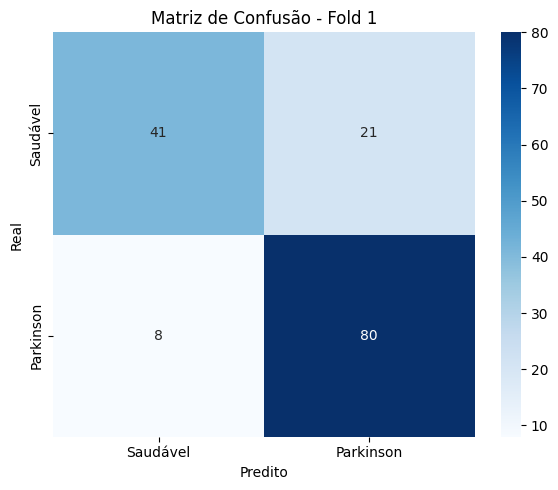

Fold 2 - Accuracy: 0.8067 | Precision: 0.8063 | Recall: 0.8067 | F1: 0.8064
              precision    recall  f1-score   support

    Saudável       0.77      0.76      0.76        62
   Parkinson       0.83      0.84      0.84        88

    accuracy                           0.81       150
   macro avg       0.80      0.80      0.80       150
weighted avg       0.81      0.81      0.81       150



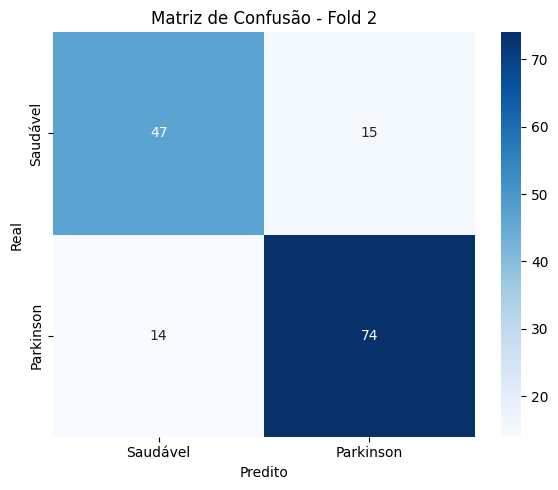

Fold 3 - Accuracy: 0.7919 | Precision: 0.7912 | Recall: 0.7919 | F1: 0.7897
              precision    recall  f1-score   support

    Saudável       0.78      0.69      0.74        62
   Parkinson       0.80      0.86      0.83        87

    accuracy                           0.79       149
   macro avg       0.79      0.78      0.78       149
weighted avg       0.79      0.79      0.79       149



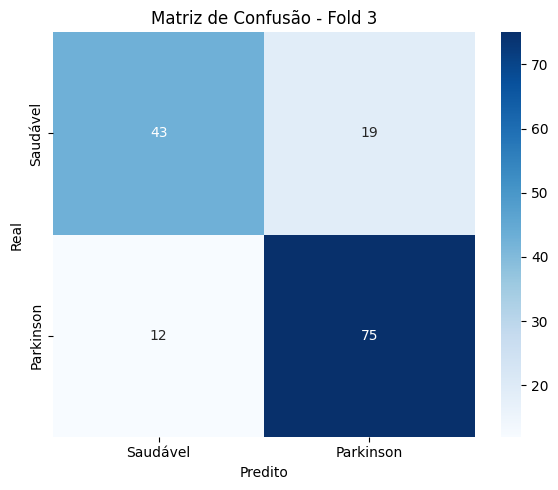

Fold 4 - Accuracy: 0.8389 | Precision: 0.8400 | Recall: 0.8389 | F1: 0.8369
              precision    recall  f1-score   support

    Saudável       0.85      0.74      0.79        62
   Parkinson       0.83      0.91      0.87        87

    accuracy                           0.84       149
   macro avg       0.84      0.82      0.83       149
weighted avg       0.84      0.84      0.84       149



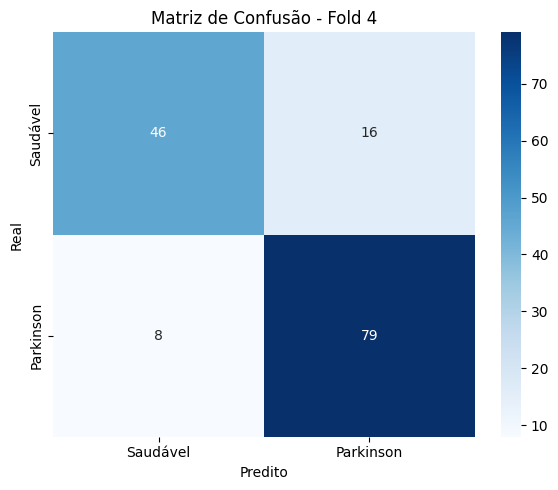

Fold 5 - Accuracy: 0.8389 | Precision: 0.8384 | Recall: 0.8389 | F1: 0.8381
              precision    recall  f1-score   support

    Saudável       0.83      0.77      0.80        62
   Parkinson       0.85      0.89      0.87        87

    accuracy                           0.84       149
   macro avg       0.84      0.83      0.83       149
weighted avg       0.84      0.84      0.84       149



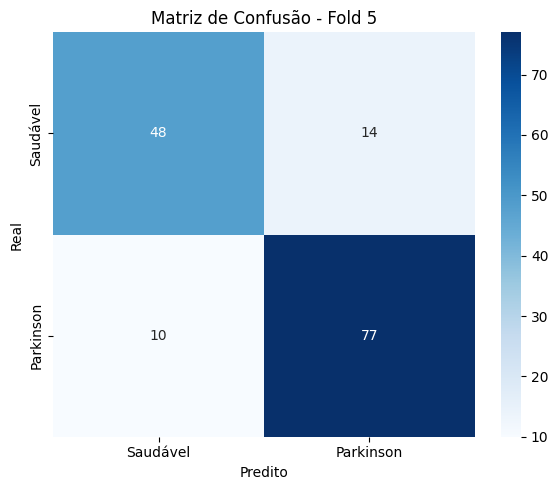


==== MÉDIAS GERAIS ====
Accuracy: 0.8166 ± 0.0190
Precision: 0.8173 ± 0.0190
Recall: 0.8166 ± 0.0190
F1 Score: 0.8146 ± 0.0194


In [ ]:
# avaliando modelo SVM
avaliar_modelo_kfold(X, y_binario, SVC, parametros_svm_binario, ['Saudável', 'Parkinson'], binarizar_labels)

#### **Com redução de dimensionalidade - PCA**

##### Otimização de hiperparâmetros com Optuna

In [ ]:
# SVM binário com PCA
pruner = SuccessiveHalvingPruner(min_resource=2, reduction_factor=3)
study_svm_binario_pca = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=pruner)

study_svm_binario_pca.optimize(lambda trial: objective(trial, X, y_binario, 'svm', usar_pca=True), n_trials=100, n_jobs=1)

parametros_svm_binario_pca = study_svm_binario_pca.best_params

print("SVM melhores parâmetros:", study_svm_binario_pca.best_params)
print("SVM melhor score:", study_svm_binario_pca.best_value)

[I 2025-05-21 17:16:31,173] A new study created in memory with name: no-name-d3db3c88-eb70-4671-a45a-f3032c32e56e
[I 2025-05-21 17:16:36,150] Trial 0 finished with value: 0.6833765586385181 and parameters: {'C': 0.05753773794117188, 'gamma': 0.008627358286640185, 'n_components': 89}. Best is trial 0 with value: 0.6833765586385181.
[I 2025-05-21 17:16:38,364] Trial 1 finished with value: 0.7195444870778811 and parameters: {'C': 0.6502468545951017, 'gamma': 0.0007979118876474872, 'n_components': 23}. Best is trial 1 with value: 0.7195444870778811.
[I 2025-05-21 17:16:39,649] Trial 2 pruned. 
[I 2025-05-21 17:16:41,981] Trial 3 finished with value: 0.7543029797346987 and parameters: {'C': 2.124280213720889, 'gamma': 0.0005318033256270141, 'n_components': 117}. Best is trial 3 with value: 0.7543029797346987.
[I 2025-05-21 17:16:44,395] Trial 4 finished with value: 0.7802590643763815 and parameters: {'C': 8.158738235092015, 'gamma': 0.00094456001380947, 'n_components': 26}. Best is trial 4 

SVM melhores parâmetros: {'C': 4.108687536301453, 'gamma': 0.0033670923232691384, 'n_components': 52}
SVM melhor score: 0.8262380142698291


##### Avaliação do modelo com kfold

Fold 1 - Accuracy: 0.8067 | Precision: 0.8062 | Recall: 0.8067 | F1: 0.8046
              precision    recall  f1-score   support

    Saudável       0.80      0.71      0.75        62
   Parkinson       0.81      0.88      0.84        88

    accuracy                           0.81       150
   macro avg       0.81      0.79      0.80       150
weighted avg       0.81      0.81      0.80       150



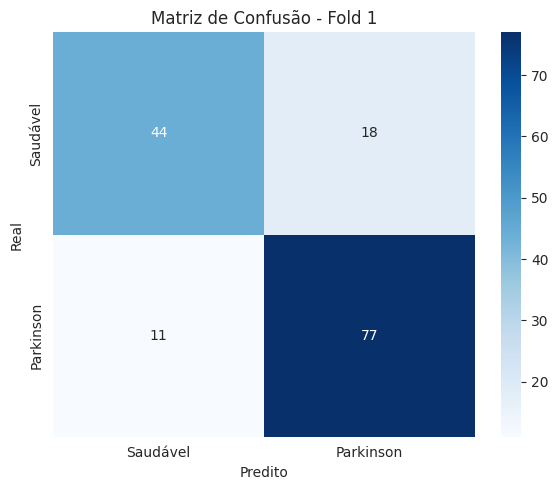

Fold 2 - Accuracy: 0.8067 | Precision: 0.8063 | Recall: 0.8067 | F1: 0.8064
              precision    recall  f1-score   support

    Saudável       0.77      0.76      0.76        62
   Parkinson       0.83      0.84      0.84        88

    accuracy                           0.81       150
   macro avg       0.80      0.80      0.80       150
weighted avg       0.81      0.81      0.81       150



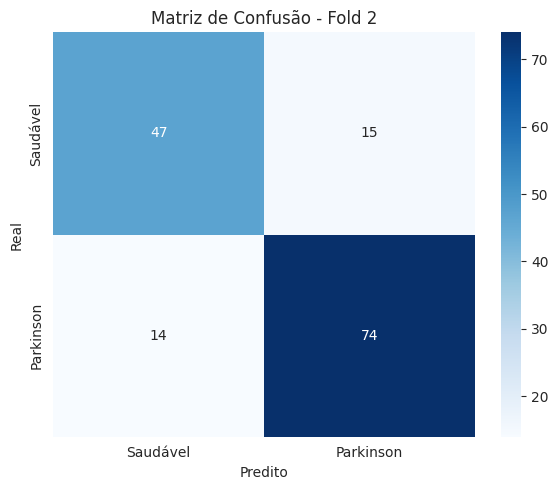

Fold 3 - Accuracy: 0.8255 | Precision: 0.8262 | Recall: 0.8255 | F1: 0.8233
              precision    recall  f1-score   support

    Saudável       0.83      0.73      0.78        62
   Parkinson       0.82      0.90      0.86        87

    accuracy                           0.83       149
   macro avg       0.83      0.81      0.82       149
weighted avg       0.83      0.83      0.82       149



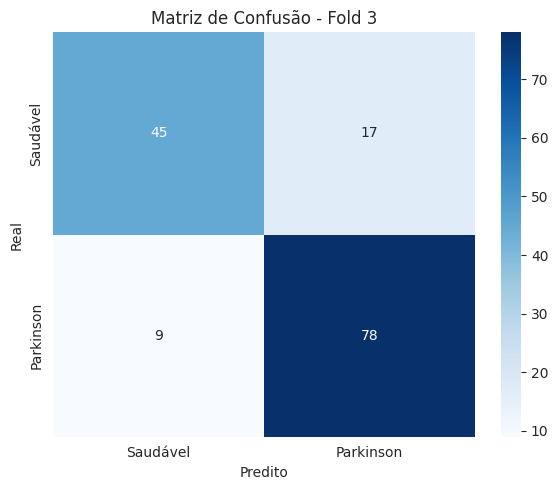

Fold 4 - Accuracy: 0.8591 | Precision: 0.8587 | Recall: 0.8591 | F1: 0.8585
              precision    recall  f1-score   support

    Saudável       0.85      0.81      0.83        62
   Parkinson       0.87      0.90      0.88        87

    accuracy                           0.86       149
   macro avg       0.86      0.85      0.85       149
weighted avg       0.86      0.86      0.86       149



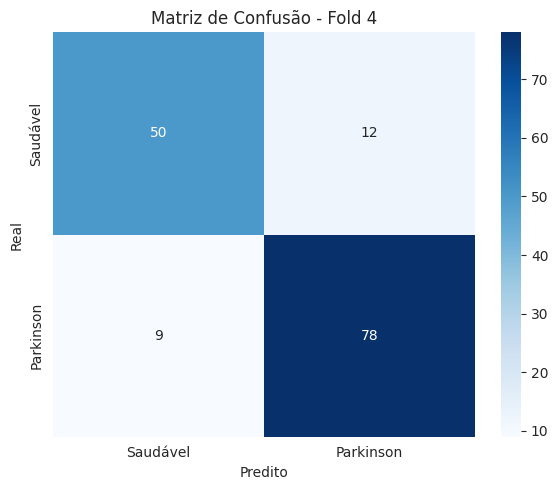

Fold 5 - Accuracy: 0.8389 | Precision: 0.8384 | Recall: 0.8389 | F1: 0.8381
              precision    recall  f1-score   support

    Saudável       0.83      0.77      0.80        62
   Parkinson       0.85      0.89      0.87        87

    accuracy                           0.84       149
   macro avg       0.84      0.83      0.83       149
weighted avg       0.84      0.84      0.84       149



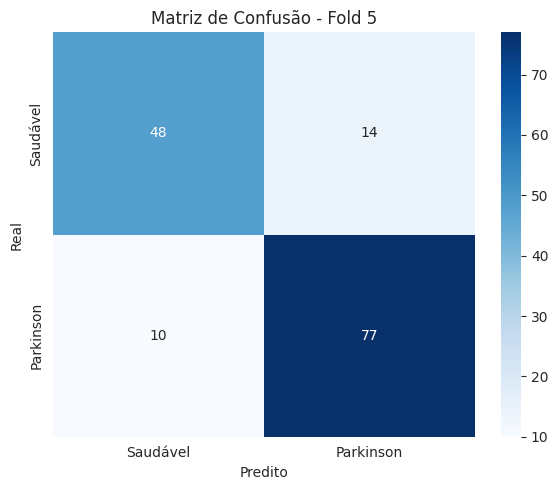


==== MÉDIAS GERAIS ====
Accuracy: 0.8274 ± 0.0200
Precision: 0.8271 ± 0.0200
Recall: 0.8274 ± 0.0200
F1 Score: 0.8262 ± 0.0203


In [ ]:
# avaliando modelo SVM binário com PCA
avaliar_modelo_kfold(X, y_binario, SVC, parametros_svm_binario_pca, ['Saudável', 'Parkinson'], binarizar_labels)

### **Resultados e Conclusão SVM**

| Tipo de Classificação         | Redução de Dimensionalidade | Acurácia Média        | F1-score Médio        |
| ----------------------------- | --------------------------- | --------------------- | -------------------- |
| **SVM Multiclasse** | Não     | 0.7966 ± 0.0211   | 0.7944 ± 0.0207   |
|                     | Sim     | 0.7925 ± 0.0128    | 0.7863 ± 0.0144    |
|                               | **Impacto da Redução**      | **- 0.0041**     | **- 0.0081**     |
| **SVM Binário**     | Não     | 0.8166 ± 0.0190    | 0.8146 ± 0.0194    |
|                     | Sim     | 0.8274 ± 0.0200    | 0.8262 ± 0.0203    |
|                               | **Impacto da Redução**      | **+ 0.0108**     | **+ 0.0116**     |

Diferentemente do Random Forest, o desempenho do SVM variou com a redução de dimensionalidade. Na classificação multiclasse, o impacto do PCA foi mínimo, com quedas marginais de 0.0041 na acurácia e 0.0081 no F1-score. No entanto, na versão binária, o uso do PCA melhorou os resultados: a acurácia aumentou em 0.0108 e o F1-score em 0.0116. Isso indica que o SVM pode se beneficiar da redução de dimensionalidade em cenários binários, possivelmente por tornar o espaço de decisão mais simples e menos sujeito a overfitting.

## **XGBoost**


### **XGBoost - Multiclasse**

#### **Sem redução de dimensionalidade**

##### Otimização de hiperparâmetros com Optuna

In [ ]:
# XGBoost multiclasse
pruner = SuccessiveHalvingPruner(min_resource=2, reduction_factor=3)
study_xgb_4classes = optuna.create_study(
    direction='maximize', sampler=optuna.samplers.TPESampler(seed=42),
    pruner=pruner)

study_xgb_4classes.optimize(lambda trial: objective(trial, X, y_4classes, 'xgboost'), n_trials=50, n_jobs=1)

parametros_xgb_4classes = study_xgb_4classes.best_params

print("XGB melhores parâmetros:", study_xgb_4classes.best_params)
print("XGB melhor score:", study_xgb_4classes.best_value)


[I 2025-05-21 18:37:44,011] A new study created in memory with name: no-name-fa7f54a0-60ce-487d-a4a4-ff87b41c9c5a
[I 2025-05-21 18:38:08,550] Trial 0 finished with value: 0.784728797824683 and parameters: {'n_estimators': 144, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997}. Best is trial 0 with value: 0.784728797824683.
[I 2025-05-21 18:41:08,817] Trial 1 finished with value: 0.7821034209406147 and parameters: {'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.010725209743171997, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 2.8483918709107956e-07, 'reg_lambda': 2.9324868872723725e-07}. Best is trial 0 with value: 0.784728797824683.
[I 2025-05-21 18:41:47,589] Trial 2 pruned. 
[I 2025-05-21 18:43:32,084] Trial 3 pruned. 
[I 2025-05-2

XGB melhores parâmetros: {'n_estimators': 135, 'max_depth': 11, 'learning_rate': 0.056443696201909005, 'subsample': 0.6916234475173693, 'colsample_bytree': 0.6383885510145398, 'gamma': 0.05048851336512933, 'reg_alpha': 0.20435290138162712, 'reg_lambda': 5.747197715801371e-05}
XGB melhor score: 0.802747456394967


##### Avaliação do modelo com kfold

Fold 1 - Accuracy: 0.7400 | Precision: 0.7294 | Recall: 0.7400 | F1: 0.7288
              precision    recall  f1-score   support

  Saudável 0       0.50      0.35      0.41        23
  Saudável 1       0.76      0.87      0.81        39
 Parkinson 2       0.77      0.86      0.81        57
 Parkinson 3       0.80      0.65      0.71        31

    accuracy                           0.74       150
   macro avg       0.71      0.68      0.69       150
weighted avg       0.73      0.74      0.73       150



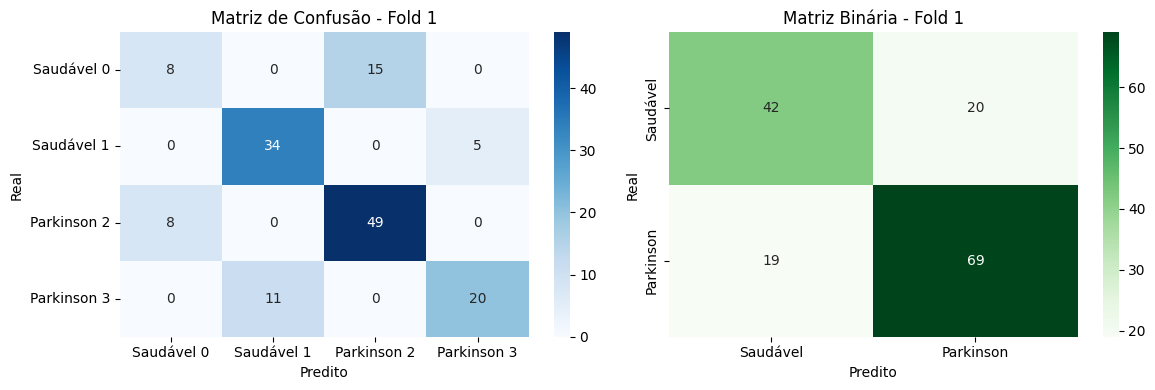

Fold 2 - Accuracy: 0.8000 | Precision: 0.7963 | Recall: 0.8000 | F1: 0.7913
              precision    recall  f1-score   support

  Saudável 0       0.73      0.48      0.58        23
  Saudável 1       0.79      0.87      0.83        39
 Parkinson 2       0.82      0.93      0.87        57
 Parkinson 3       0.81      0.71      0.76        31

    accuracy                           0.80       150
   macro avg       0.79      0.75      0.76       150
weighted avg       0.80      0.80      0.79       150



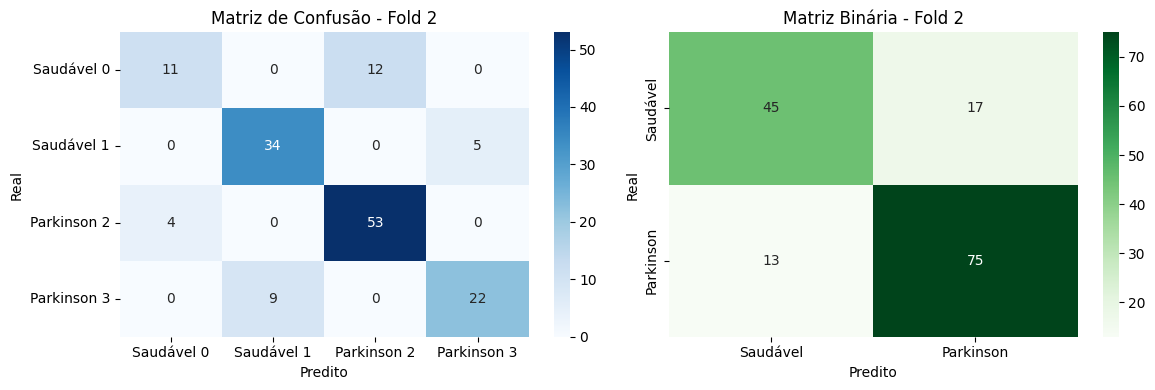

Fold 3 - Accuracy: 0.8188 | Precision: 0.8163 | Recall: 0.8188 | F1: 0.8156
              precision    recall  f1-score   support

  Saudável 0       0.67      0.55      0.60        22
  Saudável 1       0.89      0.82      0.86        40
 Parkinson 2       0.84      0.89      0.86        57
 Parkinson 3       0.79      0.87      0.83        30

    accuracy                           0.82       149
   macro avg       0.80      0.78      0.79       149
weighted avg       0.82      0.82      0.82       149



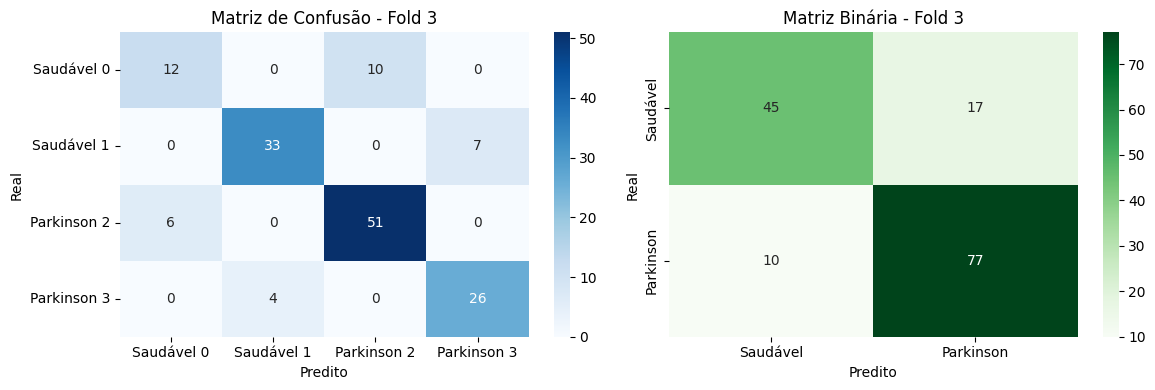

Fold 4 - Accuracy: 0.8523 | Precision: 0.8535 | Recall: 0.8523 | F1: 0.8526
              precision    recall  f1-score   support

  Saudável 0       0.77      0.77      0.77        22
  Saudável 1       0.87      0.82      0.85        40
 Parkinson 2       0.91      0.91      0.91        57
 Parkinson 3       0.78      0.83      0.81        30

    accuracy                           0.85       149
   macro avg       0.83      0.84      0.83       149
weighted avg       0.85      0.85      0.85       149



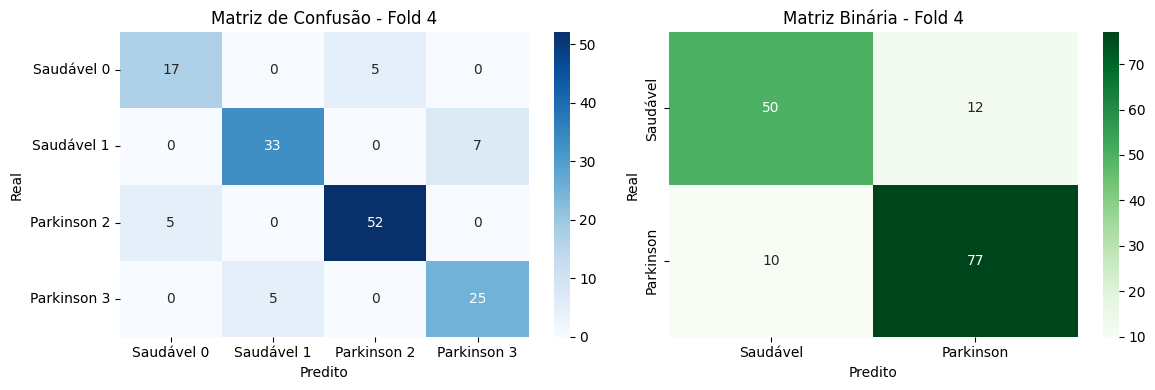

Fold 5 - Accuracy: 0.8121 | Precision: 0.8146 | Recall: 0.8121 | F1: 0.8018
              precision    recall  f1-score   support

  Saudável 0       0.79      0.50      0.61        22
  Saudável 1       0.77      0.93      0.84        40
 Parkinson 2       0.83      0.95      0.89        57
 Parkinson 3       0.86      0.63      0.73        30

    accuracy                           0.81       149
   macro avg       0.81      0.75      0.77       149
weighted avg       0.81      0.81      0.80       149



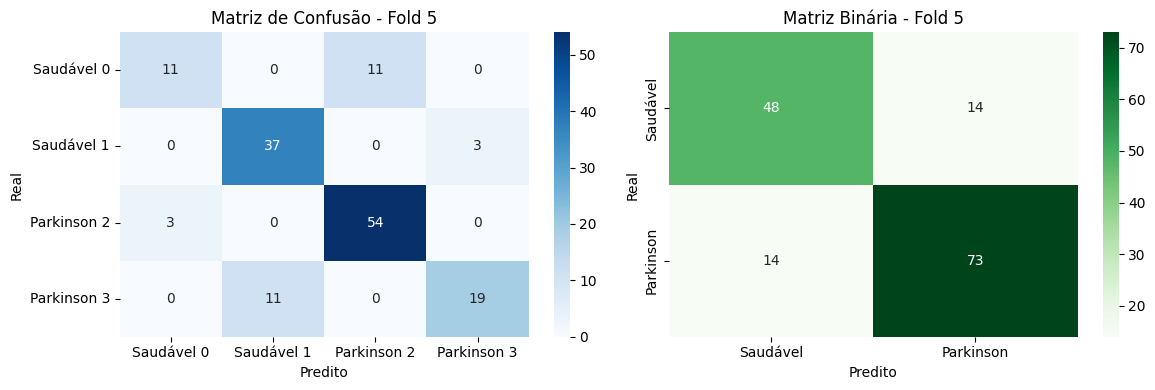


==== MÉDIAS GERAIS ====
Accuracy: 0.8046 ± 0.0367
Precision: 0.8020 ± 0.0408
Recall: 0.8046 ± 0.0367
F1 Score: 0.7980 ± 0.0404


In [ ]:
# avaliando modelo Xgboost multiclasse
avaliar_modelo_kfold(X, y_4classes, XGBClassifier, parametros_xgb_4classes, ['Saudável 0', 'Saudável 1', 'Parkinson 2', 'Parkinson 3'], binarizar_labels)

#### **Com redução de dimensionalidade - PCA**

##### Otimização de hiperparâmetros com Optuna

In [ ]:
# XGBoost multiclasse com pca
pruner = SuccessiveHalvingPruner(min_resource=2, reduction_factor=3)
study_xgb_4classes_pca = optuna.create_study(
    direction='maximize', sampler=optuna.samplers.TPESampler(seed=42),
    pruner=pruner)

study_xgb_4classes_pca.optimize(lambda trial: objective(trial, X, y_4classes, 'xgboost', usar_pca=True), n_trials=50, n_jobs=1)

parametros_xgb_4classes_pca = study_xgb_4classes_pca.best_params

print("XGB melhores parâmetros:", study_xgb_4classes_pca.best_params)
print("XGB melhor score:", study_xgb_4classes_pca.best_value)


[I 2025-05-21 15:20:46,861] A new study created in memory with name: no-name-329d5967-de64-483a-8224-84d8b19e260f
[I 2025-05-21 15:20:56,446] Trial 0 finished with value: 0.7769402471579537 and parameters: {'n_estimators': 144, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'n_components': 74}. Best is trial 0 with value: 0.7769402471579537.
[I 2025-05-21 15:21:02,737] Trial 1 finished with value: 0.7616900100312256 and parameters: {'n_estimators': 227, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'gamma': 0.9091248360355031, 'reg_alpha': 2.9324868872723725e-07, 'reg_lambda': 2.716051144654844e-06, 'n_components': 65}. Best is trial 0 with value: 0.7769402471579537.
[I 2025-05-21 15:21:05,405] Trial 2 pruned. 
[I 2025-05-21 15:2

XGB melhores parâmetros: {'n_estimators': 146, 'max_depth': 12, 'learning_rate': 0.016205954558414316, 'subsample': 0.887006239708728, 'colsample_bytree': 0.5375673433598886, 'gamma': 0.5659138128671711, 'reg_alpha': 6.851487052534492e-08, 'reg_lambda': 0.9306704438023279, 'n_components': 28}
XGB melhor score: 0.7845868602901842


##### Avaliação do modelo com kfold

Fold 1 - Accuracy: 0.7200 | Precision: 0.7108 | Recall: 0.7200 | F1: 0.7061
              precision    recall  f1-score   support

  Saudável 0       0.44      0.30      0.36        23
  Saudável 1       0.73      0.90      0.80        39
 Parkinson 2       0.75      0.84      0.79        57
 Parkinson 3       0.82      0.58      0.68        31

    accuracy                           0.72       150
   macro avg       0.68      0.66      0.66       150
weighted avg       0.71      0.72      0.71       150



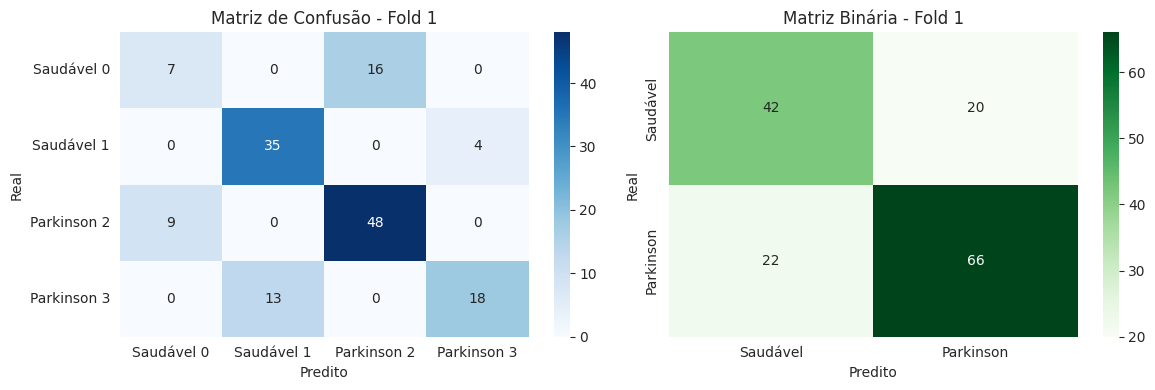

Fold 2 - Accuracy: 0.7800 | Precision: 0.7754 | Recall: 0.7800 | F1: 0.7715
              precision    recall  f1-score   support

  Saudável 0       0.73      0.48      0.58        23
  Saudável 1       0.76      0.82      0.79        39
 Parkinson 2       0.82      0.93      0.87        57
 Parkinson 3       0.75      0.68      0.71        31

    accuracy                           0.78       150
   macro avg       0.77      0.73      0.74       150
weighted avg       0.78      0.78      0.77       150



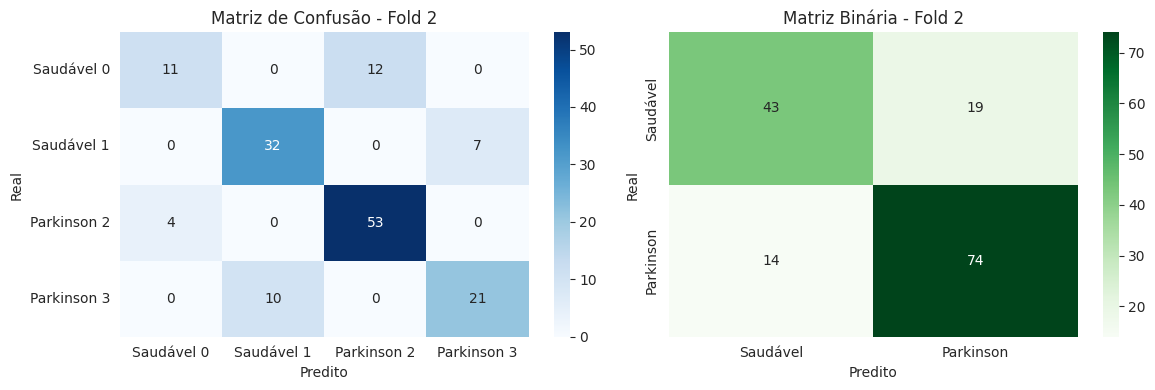

Fold 3 - Accuracy: 0.8054 | Precision: 0.7990 | Recall: 0.8054 | F1: 0.7962
              precision    recall  f1-score   support

  Saudável 0       0.64      0.41      0.50        22
  Saudável 1       0.89      0.82      0.86        40
 Parkinson 2       0.80      0.91      0.85        57
 Parkinson 3       0.79      0.87      0.83        30

    accuracy                           0.81       149
   macro avg       0.78      0.75      0.76       149
weighted avg       0.80      0.81      0.80       149



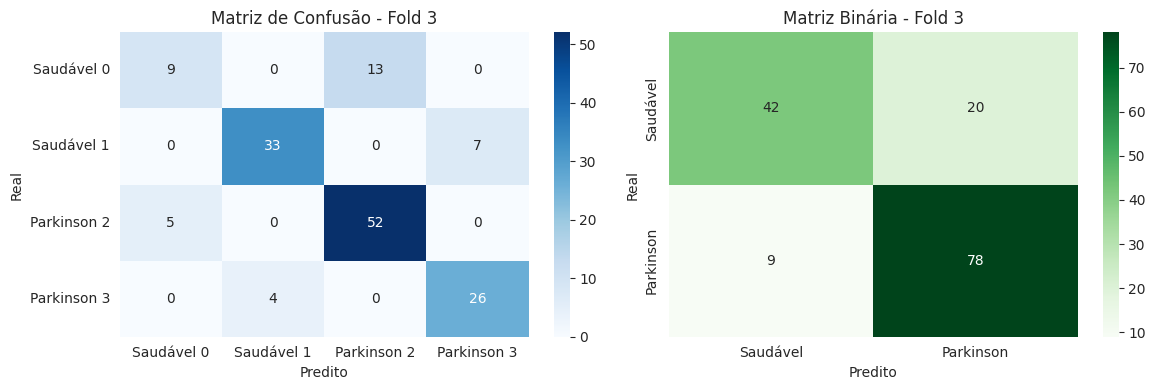

Fold 4 - Accuracy: 0.8389 | Precision: 0.8385 | Recall: 0.8389 | F1: 0.8376
              precision    recall  f1-score   support

  Saudável 0       0.79      0.68      0.73        22
  Saudável 1       0.87      0.82      0.85        40
 Parkinson 2       0.87      0.91      0.89        57
 Parkinson 3       0.78      0.83      0.81        30

    accuracy                           0.84       149
   macro avg       0.83      0.81      0.82       149
weighted avg       0.84      0.84      0.84       149



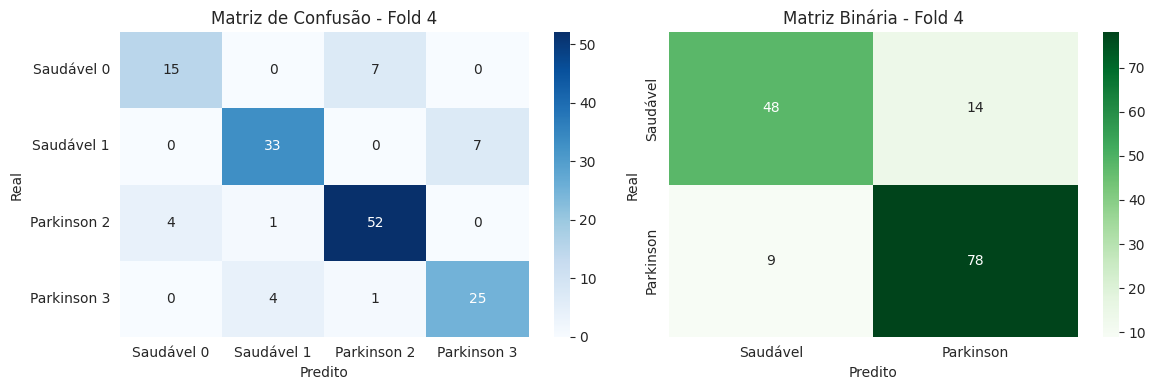

Fold 5 - Accuracy: 0.7919 | Precision: 0.7913 | Recall: 0.7919 | F1: 0.7816
              precision    recall  f1-score   support

  Saudável 0       0.79      0.50      0.61        22
  Saudável 1       0.74      0.88      0.80        40
 Parkinson 2       0.83      0.95      0.89        57
 Parkinson 3       0.78      0.60      0.68        30

    accuracy                           0.79       149
   macro avg       0.79      0.73      0.75       149
weighted avg       0.79      0.79      0.78       149



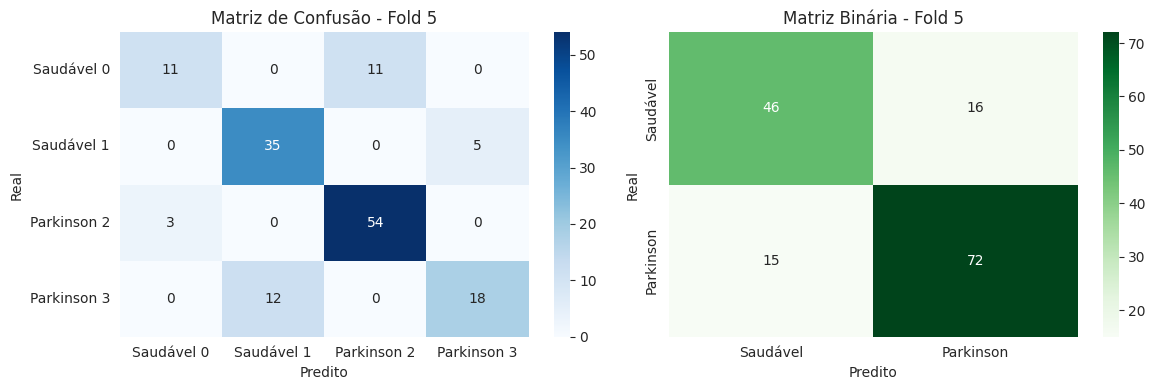


==== MÉDIAS GERAIS ====
Accuracy: 0.7872 ± 0.0390
Precision: 0.7830 ± 0.0417
Recall: 0.7872 ± 0.0390
F1 Score: 0.7786 ± 0.0427


In [ ]:
# avaliando modelo Xgboost multiclasse com pca
avaliar_modelo_kfold(X, y_4classes, XGBClassifier, parametros_xgb_4classes_pca, ['Saudável 0', 'Saudável 1', 'Parkinson 2', 'Parkinson 3'], binarizar_labels)

### **XGBoost - binário**

#### **Sem redução de dimensionalidade**

##### Otimização de hiperparâmetros com Optuna




In [ ]:
# XGBoost
pruner = SuccessiveHalvingPruner(min_resource=2, reduction_factor=3)
study_xgb_binario = optuna.create_study(
    direction='maximize', sampler=optuna.samplers.TPESampler(seed=42),
    pruner=pruner
    )

study_xgb_binario.optimize(lambda trial: objective(trial, X, y_binario, 'xgboostBIN'), n_trials=50, n_jobs=1)

parametros_xgb_binario = study_xgb_binario.best_params

print("XGB melhores parâmetros:", study_xgb_binario.best_params)
print("XGB melhor score:", study_xgb_binario.best_value)


[I 2025-05-21 19:08:23,987] A new study created in memory with name: no-name-e6087b76-bf84-43c7-9f05-f1541458710e
[I 2025-05-21 19:08:36,975] Trial 0 finished with value: 0.7858315990329944 and parameters: {'n_estimators': 144, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997}. Best is trial 0 with value: 0.7858315990329944.
[I 2025-05-21 19:10:04,186] Trial 1 finished with value: 0.7900993761929974 and parameters: {'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.010725209743171997, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 2.8483918709107956e-07, 'reg_lambda': 2.9324868872723725e-07}. Best is trial 1 with value: 0.7900993761929974.
[I 2025-05-21 19:10:33,183] Trial 2 finished with value: 0.7991746712401985 and parameters: {'n_est

XGB melhores parâmetros: {'n_estimators': 271, 'max_depth': 4, 'learning_rate': 0.05158982366586951, 'subsample': 0.5479183198996584, 'colsample_bytree': 0.5777071883914722, 'gamma': 0.5799610638095529, 'reg_alpha': 0.001650252460591608, 'reg_lambda': 0.00018702723837359052}
XGB melhor score: 0.8141398379327551


##### Avaliação do modelo com kfold

Fold 1 - Accuracy: 0.8133 | Precision: 0.8125 | Recall: 0.8133 | F1: 0.8123
              precision    recall  f1-score   support

    Saudável       0.79      0.74      0.77        62
   Parkinson       0.83      0.86      0.84        88

    accuracy                           0.81       150
   macro avg       0.81      0.80      0.81       150
weighted avg       0.81      0.81      0.81       150



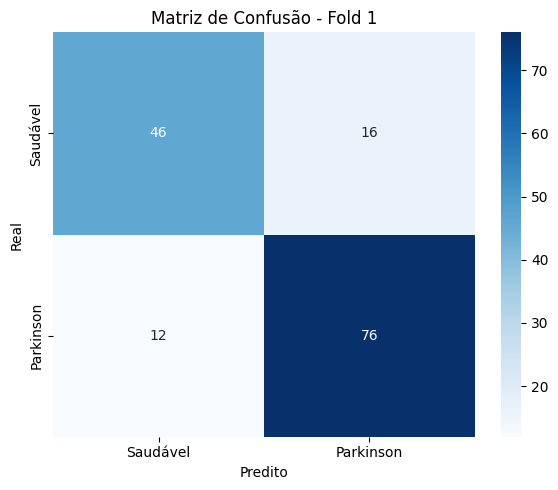

Fold 2 - Accuracy: 0.7667 | Precision: 0.7706 | Recall: 0.7667 | F1: 0.7678
              precision    recall  f1-score   support

    Saudável       0.70      0.76      0.73        62
   Parkinson       0.82      0.77      0.80        88

    accuracy                           0.77       150
   macro avg       0.76      0.77      0.76       150
weighted avg       0.77      0.77      0.77       150



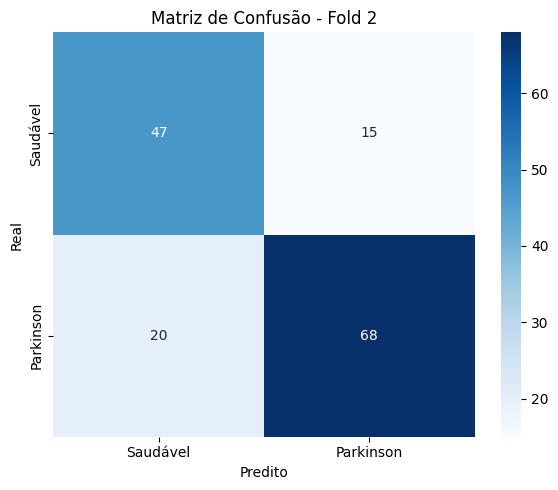

Fold 3 - Accuracy: 0.7651 | Precision: 0.7636 | Recall: 0.7651 | F1: 0.7626
              precision    recall  f1-score   support

    Saudável       0.75      0.66      0.70        62
   Parkinson       0.78      0.84      0.81        87

    accuracy                           0.77       149
   macro avg       0.76      0.75      0.75       149
weighted avg       0.76      0.77      0.76       149



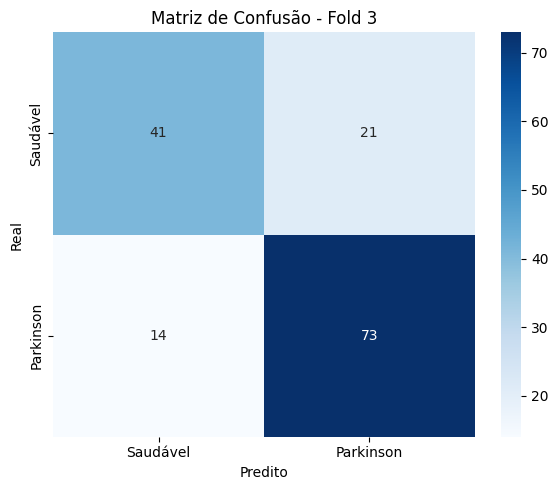

Fold 4 - Accuracy: 0.8255 | Precision: 0.8252 | Recall: 0.8255 | F1: 0.8240
              precision    recall  f1-score   support

    Saudável       0.82      0.74      0.78        62
   Parkinson       0.83      0.89      0.86        87

    accuracy                           0.83       149
   macro avg       0.82      0.81      0.82       149
weighted avg       0.83      0.83      0.82       149



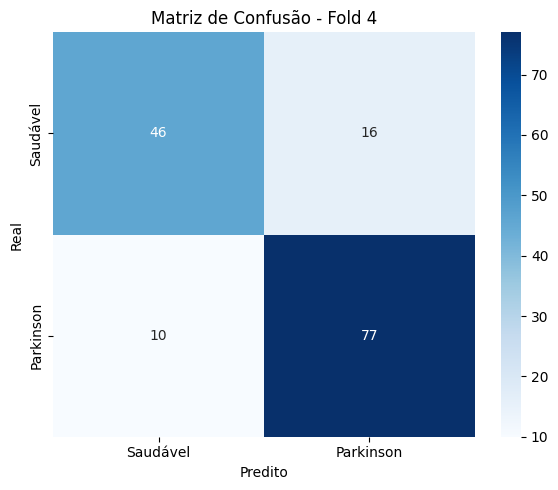

Fold 5 - Accuracy: 0.7919 | Precision: 0.7909 | Recall: 0.7919 | F1: 0.7905
              precision    recall  f1-score   support

    Saudável       0.77      0.71      0.74        62
   Parkinson       0.80      0.85      0.83        87

    accuracy                           0.79       149
   macro avg       0.79      0.78      0.78       149
weighted avg       0.79      0.79      0.79       149



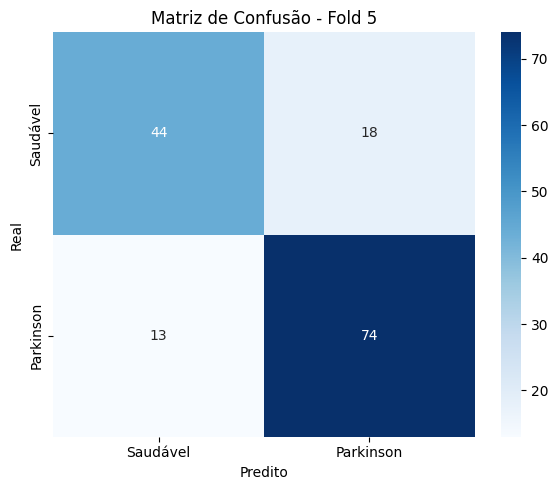


==== MÉDIAS GERAIS ====
Accuracy: 0.7925 ± 0.0243
Precision: 0.7926 ± 0.0236
Recall: 0.7925 ± 0.0243
F1 Score: 0.7914 ± 0.0240


In [ ]:
# avaliando modelo Xgboost
avaliar_modelo_kfold(X, y_binario, XGBClassifier, parametros_xgb_binario, ['Saudável', 'Parkinson'], binarizar_labels)

#### **Com redução de dimensionalidade - PCA**

##### Otimização de hiperparâmetros com Optuna

In [ ]:
# XGBoost
pruner = SuccessiveHalvingPruner(min_resource=2, reduction_factor=3)
study_xgb_binario_pca = optuna.create_study(
    direction='maximize', sampler=optuna.samplers.TPESampler(seed=42),
    pruner=pruner
    )

study_xgb_binario_pca.optimize(lambda trial: objective(trial, X, y_binario, 'xgboostBIN', usar_pca=True), n_trials=50, n_jobs=1)

parametros_xgb_binario_pca = study_xgb_binario_pca.best_params

print("XGB melhores parâmetros:", study_xgb_binario_pca.best_params)
print("XGB melhor score:", study_xgb_binario_pca.best_value)

[I 2025-05-21 17:49:49,264] A new study created in memory with name: no-name-df2dbeea-4079-41d8-81f2-3014d66afa2a
[I 2025-05-21 17:49:54,547] Trial 0 finished with value: 0.773483587448594 and parameters: {'n_estimators': 144, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 2.9152036385288193e-08, 'reg_lambda': 0.08499808989182997, 'n_components': 74}. Best is trial 0 with value: 0.773483587448594.
[I 2025-05-21 17:49:59,298] Trial 1 finished with value: 0.7620283247524582 and parameters: {'n_estimators': 227, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'gamma': 0.9091248360355031, 'reg_alpha': 2.9324868872723725e-07, 'reg_lambda': 2.716051144654844e-06, 'n_components': 65}. Best is trial 0 with value: 0.773483587448594.
[I 2025-05-21 17:50:02,643] Trial 2 finished with value: 0.7847829

XGB melhores parâmetros: {'n_estimators': 144, 'max_depth': 15, 'learning_rate': 0.08853874505145645, 'subsample': 0.8119514567516845, 'colsample_bytree': 0.9972390767643127, 'gamma': 0.02333746153513383, 'reg_alpha': 1.3358874231661313e-06, 'reg_lambda': 0.06407335081864933, 'n_components': 78}
XGB melhor score: 0.8006112302314872


##### Avaliação do modelo com kfold

Fold 1 - Accuracy: 0.7667 | Precision: 0.7651 | Recall: 0.7667 | F1: 0.7641
              precision    recall  f1-score   support

    Saudável       0.75      0.66      0.70        62
   Parkinson       0.78      0.84      0.81        88

    accuracy                           0.77       150
   macro avg       0.76      0.75      0.75       150
weighted avg       0.77      0.77      0.76       150



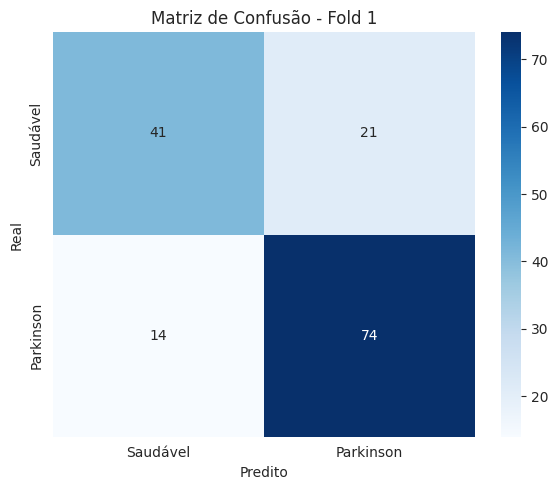

Fold 2 - Accuracy: 0.7867 | Precision: 0.7859 | Recall: 0.7867 | F1: 0.7861
              precision    recall  f1-score   support

    Saudável       0.75      0.73      0.74        62
   Parkinson       0.81      0.83      0.82        88

    accuracy                           0.79       150
   macro avg       0.78      0.78      0.78       150
weighted avg       0.79      0.79      0.79       150



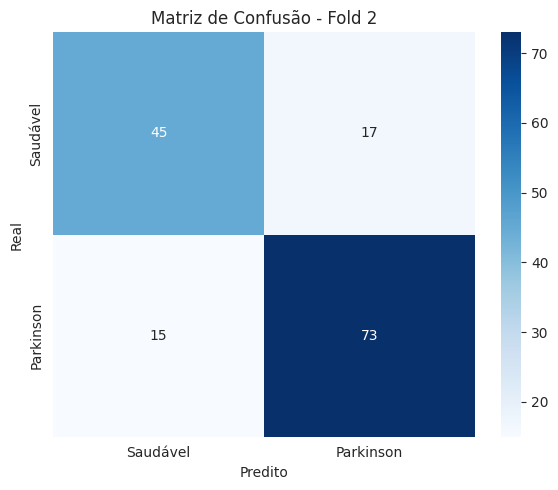

Fold 3 - Accuracy: 0.7785 | Precision: 0.7772 | Recall: 0.7785 | F1: 0.7770
              precision    recall  f1-score   support

    Saudável       0.75      0.69      0.72        62
   Parkinson       0.79      0.84      0.82        87

    accuracy                           0.78       149
   macro avg       0.77      0.77      0.77       149
weighted avg       0.78      0.78      0.78       149



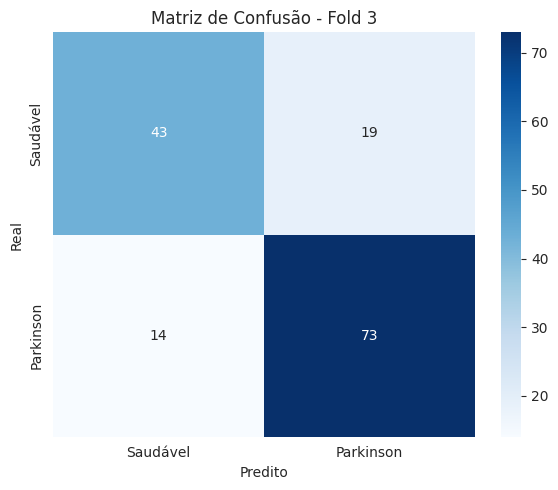

Fold 4 - Accuracy: 0.8255 | Precision: 0.8249 | Recall: 0.8255 | F1: 0.8251
              precision    recall  f1-score   support

    Saudável       0.80      0.77      0.79        62
   Parkinson       0.84      0.86      0.85        87

    accuracy                           0.83       149
   macro avg       0.82      0.82      0.82       149
weighted avg       0.82      0.83      0.83       149



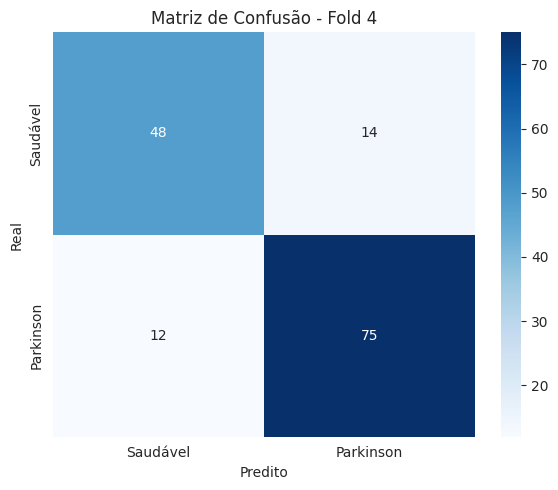

Fold 5 - Accuracy: 0.7987 | Precision: 0.7978 | Recall: 0.7987 | F1: 0.7969
              precision    recall  f1-score   support

    Saudável       0.79      0.71      0.75        62
   Parkinson       0.81      0.86      0.83        87

    accuracy                           0.80       149
   macro avg       0.80      0.79      0.79       149
weighted avg       0.80      0.80      0.80       149



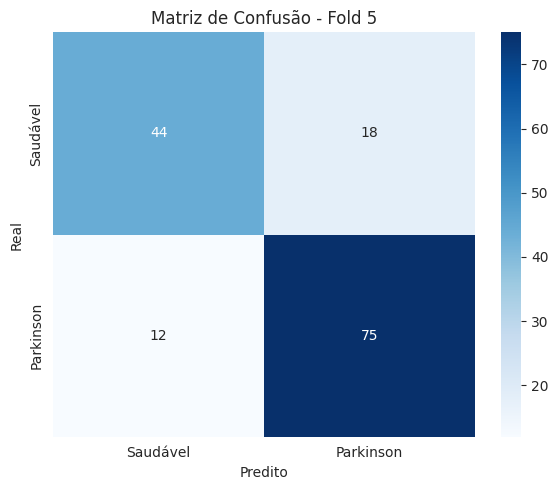


==== MÉDIAS GERAIS ====
Accuracy: 0.7912 ± 0.0201
Precision: 0.7902 ± 0.0204
Recall: 0.7912 ± 0.0201
F1 Score: 0.7898 ± 0.0206


In [ ]:
# avaliando modelo Xgboost
avaliar_modelo_kfold(X, y_binario, XGBClassifier, parametros_xgb_binario_pca, ['Saudável', 'Parkinson'], binarizar_labels)

### **Resultados e Conclusão XGBoost**

| Tipo de Classificação         | Redução de Dimensionalidade | Acurácia Média        | F1-score Médio        |
| ----------------------------- | --------------------------- | --------------------- | -------------------- |
| **XGBoost Multiclasse** | Não     | 0.8046 ± 0.0367   | 0.7980 ± 0.0404   |
|                     | Sim     | 0.7872 ± 0.0390    | 0.7786 ± 0.0427    |
|                               | **Impacto da Redução**      | **- 0.0174**     | **- 0.0194**     |
| **XGBoost Binário**     | Não     | 0.7925 ± 0.0243    | 0.7914 ± 0.0240    |
|                     | Sim     | 0.7912 ± 0.0201    | 0.7898 ± 0.0206    |
|                               | **Impacto da Redução**      | **- 0.0013**     | **- 0.0016**     |


Para o XGBoost, o impacto da redução de dimensionalidade foi negativo, ainda que em graus variados. Na tarefa multiclasse, houve uma queda de 0.0174 na acurácia e de 0.0194 no F1-score. Na classificação binária, o efeito foi praticamente nulo, com variações de apenas -0.0013 e -0.0016, respectivamente. Isso mostra que o XGBoost é robusto à presença de atributos adicionais e pouco afetado pela redução de dimensionalidade, especialmente em problemas mais simples como a classificação binária.

## **Resumo da comparação entre os modelos**
Tabela-resumo com o impacto da redução de dimensionalidade em cada modelo e tarefa:

| Modelo        | Tipo de Classificação | Δ Acurácia | Δ F1-score |
| ------------- | --------------------- | ---------- | ---------- |
| Random Forest | Multiclasse           | -0.0281    | -0.0350    |
| Random Forest | Binário               | -0.0121    | -0.0116    |
| SVM           | Multiclasse           | -0.0041    | -0.0081    |
| SVM           | Binário               | +0.0108    | +0.0116    |
| XGBoost       | Multiclasse           | -0.0174    | -0.0194    |
| XGBoost       | Binário               | -0.0013    | -0.0016    |

**Nota:** Valores positivos indicam melhora com a redução de dimensionalidade; negativos indicam piora.

## **Gráficos ROC-AUC**

------- Calculando Curva ROC multiclasse (Modelos com e sem PCA) ---------
Processando: Random Forest (Sem PCA)
Processando: SVM (Sem PCA)
Processando: XGBoost (Sem PCA)
Processando: Random Forest (PCA)
Processando: SVM (PCA)
Processando: XGBoost (PCA)


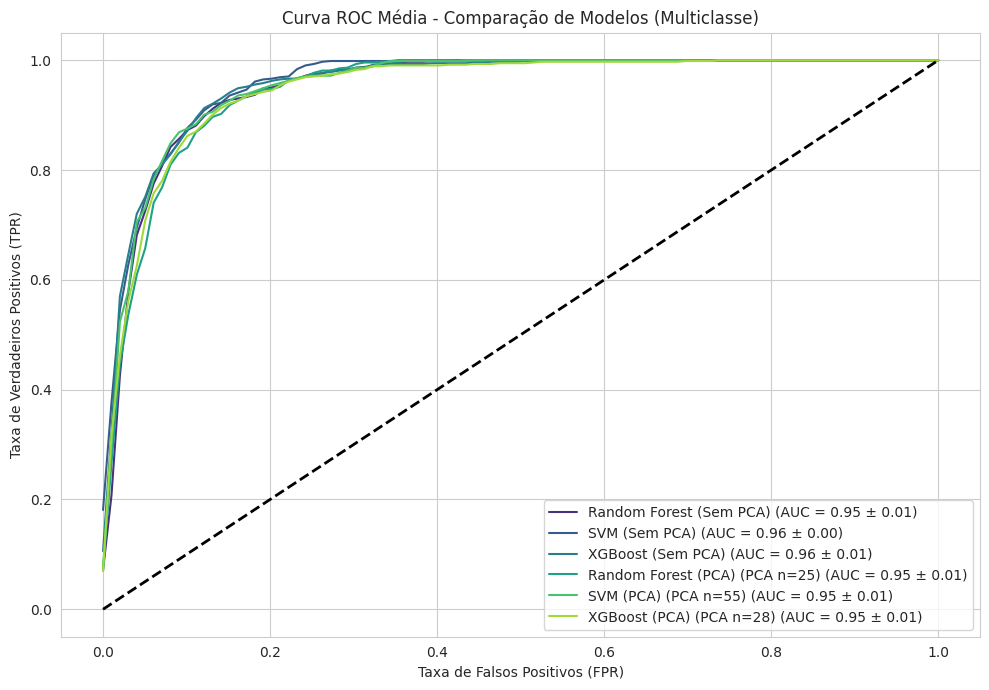


------- Calculando Curva ROC binária (Modelos com e sem PCA) ---------
Processando: Random Forest (Sem PCA)
Processando: SVM (Sem PCA)
Processando: XGBoost (Sem PCA)
Processando: Random Forest (PCA)
Processando: SVM (PCA)
Processando: XGBoost (PCA)


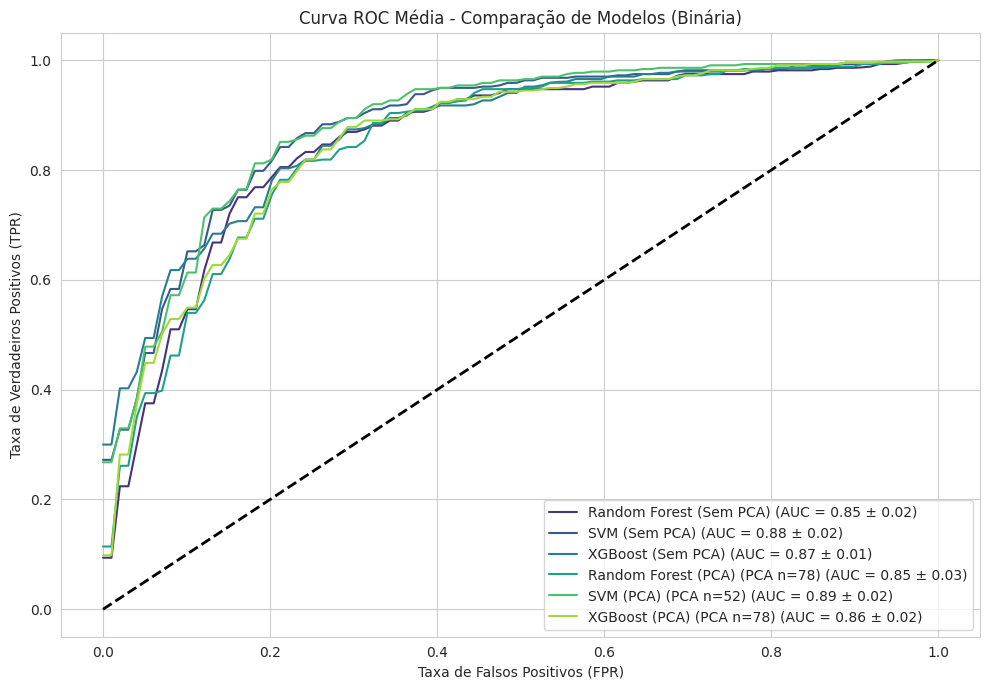

In [ ]:
# Cria cópias dos dicionários de parâmetros otimizados com PCA,
# removendo a chave 'n_components' para usá-los como argumentos nos classificadores.
# O valor de 'n_components' será armazenado separadamente para ser usado na aplicação do PCA.
parametros_rf_4classes_pca_model = parametros_rf_4classes_pca.copy()
pca_components_rf_4classes = parametros_rf_4classes_pca_model.pop('n_components', None)

parametros_svm_4classes_pca_model = parametros_svm_4classes_pca.copy()
pca_components_svm_4classes = parametros_svm_4classes_pca_model.pop('n_components', None)

parametros_xgb_4classes_pca_model = parametros_xgb_4classes_pca.copy()
pca_components_xgb_4classes = parametros_xgb_4classes_pca_model.pop('n_components', None)

parametros_rf_binario_pca_model = parametros_rf_binario_pca.copy()
pca_components_rf_binario = parametros_rf_binario_pca_model.pop('n_components', None)

parametros_svm_binario_pca_model = parametros_svm_binario_pca.copy()
pca_components_svm_binario = parametros_svm_binario_pca_model.pop('n_components', None)

parametros_xgb_binario_pca_model = parametros_xgb_binario_pca.copy()
pca_components_xgb_binario = parametros_xgb_binario_pca_model.pop('n_components', None)

# Extrai os valores de 'n_components' diretamente dos dicionários de parâmetros originais
n_components_rf_4classes_pca = parametros_rf_4classes_pca.get('n_components')
n_components_svm_4classes_pca = parametros_svm_4classes_pca.get('n_components')
n_components_xgb_4classes_pca = parametros_xgb_4classes_pca.get('n_components')

n_components_rf_binario_pca = parametros_rf_binario_pca.get('n_components')
n_components_svm_binario_pca = parametros_svm_binario_pca.get('n_components')
n_components_xgb_binario_pca = parametros_xgb_binario_pca.get('n_components')

# Soma os valores de n_components usados para cada modelo, apenas para fins de inspeção ou relatório
n_components_4classes_pca = n_components_rf_4classes_pca + n_components_svm_4classes_pca + n_components_xgb_4classes_pca
n_components_binario_pca = n_components_rf_binario_pca + n_components_svm_binario_pca + n_components_xgb_binario_pca

# ---------------------------------------------------------------------
# Geração da curva ROC para o caso multiclasse com e sem PCA
# ---------------------------------------------------------------------
print("------- Calculando Curva ROC multiclasse (Modelos com e sem PCA) ---------")

# Cria um dicionário com instâncias de modelos multiclasse:
# - Para os modelos "sem PCA", passa os parâmetros normalmente
# - Para os modelos "com PCA", usa os parâmetros (sem 'n_components') e adiciona o número de componentes separadamente
modelos_info_multiclasse = {
    "Random Forest (Sem PCA)": {"instance": RandomForestClassifier(**parametros_rf_4classes), "pca_n_components": None},
    "SVM (Sem PCA)": {"instance": SVC(**parametros_svm_4classes, probability=True), "pca_n_components": None},
    "XGBoost (Sem PCA)": {"instance": XGBClassifier(**parametros_xgb_4classes, eval_metric='mlogloss'), "pca_n_components": None},

    "Random Forest (PCA)": {
        "instance": RandomForestClassifier(**parametros_rf_4classes_pca_model),
        "pca_n_components": n_components_rf_4classes_pca
    },
    "SVM (PCA)": {
        "instance": SVC(**parametros_svm_4classes_pca_model, probability=True),
        "pca_n_components": n_components_svm_4classes_pca
    },
    "XGBoost (PCA)": {
        "instance": XGBClassifier(**parametros_xgb_4classes_pca_model, eval_metric='mlogloss'),
        "pca_n_components": n_components_xgb_4classes_pca
    }
}

# Chama a função para plotar a curva ROC dos modelos multiclasse com validação cruzada
plotar_roc_kfold(modelos_info_multiclasse, X, y_4classes)

# ---------------------------------------------------------------------
# Geração da curva ROC para o caso binário com e sem PCA
# ---------------------------------------------------------------------
print("\n------- Calculando Curva ROC binária (Modelos com e sem PCA) ---------")

# Cria um dicionário com instâncias de modelos binários:
# - Sem PCA: usa parâmetros originais
# - Com PCA: usa cópia dos parâmetros sem 'n_components' e fornece o valor separadamente
modelos_info_binario = {
    "Random Forest (Sem PCA)": {"instance": RandomForestClassifier(**parametros_rf_binario), "pca_n_components": None},
    "SVM (Sem PCA)": {"instance": SVC(**parametros_svm_binario, probability=True), "pca_n_components": None},
    "XGBoost (Sem PCA)": {"instance": XGBClassifier(**parametros_xgb_binario, eval_metric='logloss'), "pca_n_components": None},

    "Random Forest (PCA)": {
        "instance": RandomForestClassifier(**parametros_rf_binario_pca_model),
        "pca_n_components": n_components_rf_binario_pca
    },
    "SVM (PCA)": {
        "instance": SVC(**parametros_svm_binario_pca_model, probability=True),
        "pca_n_components": n_components_svm_binario_pca
    },
    "XGBoost (PCA)": {
        "instance": XGBClassifier(**parametros_xgb_binario_pca_model, eval_metric='logloss'),
        "pca_n_components": n_components_xgb_binario_pca
    }
}

# Chama a função para plotar a curva ROC dos modelos binários com validação cruzada
plotar_roc_kfold(modelos_info_binario, X, y_binario)

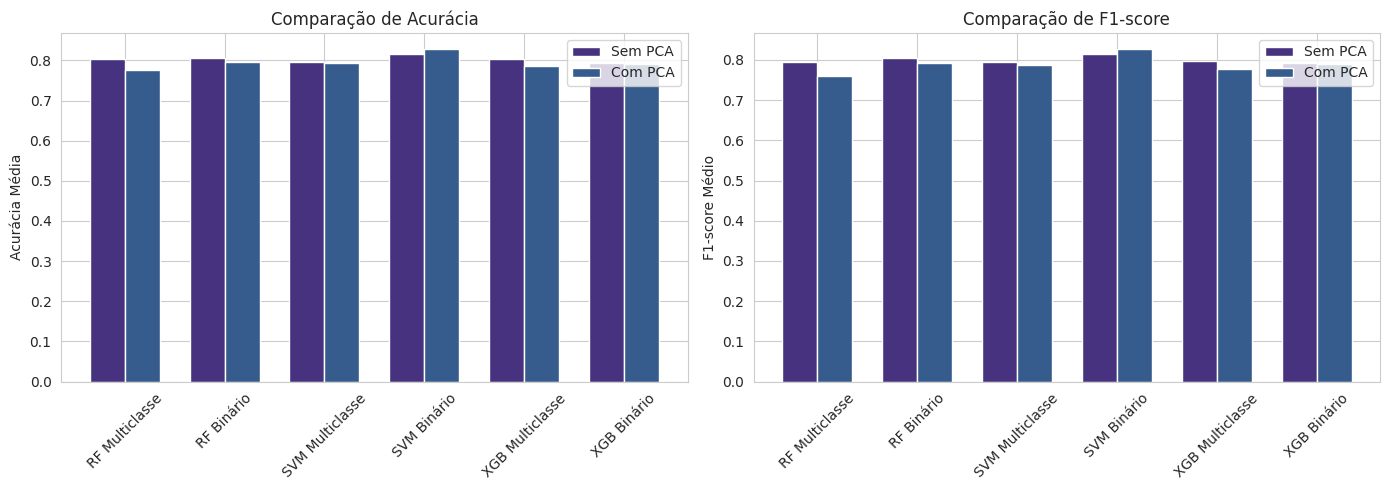

In [ ]:
# Dados para visualização
modelos = ['Random Forest', 'SVM', 'XGBoost']
classificacao = ['Multiclasse', 'Binária']

# Acurácia
acc_sem_pca = [0.8033, 0.8072, 0.7966, 0.8166, 0.8046, 0.7925]
acc_com_pca = [0.7752, 0.7951, 0.7925, 0.8274, 0.7872, 0.7912]

# F1-score
f1_sem_pca = [0.7946, 0.8051, 0.7944, 0.8146, 0.7980, 0.7914]
f1_com_pca = [0.7596, 0.7935, 0.7863, 0.8262, 0.7786, 0.7898]

# Organizando
labels = [
    'RF Multiclasse', 'RF Binário',
    'SVM Multiclasse', 'SVM Binário',
    'XGB Multiclasse', 'XGB Binário'
]
x = np.arange(len(labels))
width = 0.35

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Acurácia
axs[0].bar(x - width/2, acc_sem_pca, width, label='Sem PCA')
axs[0].bar(x + width/2, acc_com_pca, width, label='Com PCA')
axs[0].set_title('Comparação de Acurácia')
axs[0].set_ylabel('Acurácia Média')
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels, rotation=45)
axs[0].legend()

# F1-score
axs[1].bar(x - width/2, f1_sem_pca, width, label='Sem PCA')
axs[1].bar(x + width/2, f1_com_pca, width, label='Com PCA')
axs[1].set_title('Comparação de F1-score')
axs[1].set_ylabel('F1-score Médio')
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels, rotation=45)
axs[1].legend()

plt.tight_layout()
plt.show()

# **Resultados e discussão**


## **Comparativo entre os modelos**

### Acurácia e F1 score

| Tipo de Classificação         | Redução de Dimensionalidade | Acurácia Média        | F1-score Médio        |
| ----------------------------- | --------------------------- | --------------------- | -------------------- |
| **Random Forest Multiclasse** |Não| 0.8033 ± 0.0373| 0.7946 ± 0.0420    |
|                               |Sim| 0.7752 ± 0.0406| 0.7596 ± 0.0474    |
| **Random Forest Binário**     |Não| 0.8072 ± 0.0131| 0.8051 ± 0.0142    |
|                               |Sim| 0.7951 ± 0.0266| 0.7935 ± 0.0269    |
| **SVM Multiclasse** | Não | 0.7966 ± 0.0211| 0.7944 ± 0.0207   |
|                     | Sim | **0.7925 ± 0.0128**| 0.7863 ± 0.0144    |
| **SVM Binário**     | Não | **0.8166 ± 0.0190**| 0.8146 ± 0.0194    |
|                     | Sim | **0.8274 ± 0.0200**| 0.8262 ± 0.0203    |
| **XGBoost Multiclasse** | Não | **0.8046 ± 0.0367**   | 0.7980 ± 0.0404   |
|                     | Sim | 0.7872 ± 0.0390    | 0.7786 ± 0.0427    |
| **XGBoost Binário**     | Não | 0.7925 ± 0.0243    | 0.7914 ± 0.0240    |
|                     | Sim | 0.7912 ± 0.0201    | 0.7898 ± 0.0206    |

### Curva ROC-AUC

#### ROC-AUC por modelo (classificação multiclasse)

| Modelo              | PCA | AUC (média ± std) |
| ------------------- | --- | ----------------- |
| Random Forest       | Não | 0.95 ± 0.01       |
| SVM                 | Não | 0.96 ± 0.00       |
| XGBoost             | Não | 0.96 ± 0.01       |
| Random Forest (PCA) | Sim | 0.95 ± 0.01       |
| SVM (PCA)           | Sim | 0.95 ± 0.01       |
| XGBoost (PCA)       | Sim | 0.95 ± 0.01       |

#### ROC-AUC por modelo (classificação binária)

| Modelo              | PCA | AUC (média ± std) |
| ------------------- | --- | ----------------- |
| Random Forest       | Não | 0.85 ± 0.02       |
| SVM                 | Não | 0.88 ± 0.02       |
| XGBoost             | Não | 0.87 ± 0.01       |
| Random Forest (PCA) | Sim | 0.85 ± 0.03       |
| SVM (PCA)           | Sim | 0.89 ± 0.02       |
| XGBoost (PCA)       | Sim | 0.86 ± 0.02       |

> **Nota sobre a métrica AUC entre classificações binária e multiclasse:**
Os valores de AUC apresentados nas tabelas referem-se à performance dentro de cada tipo de tarefa e não devem ser comparados diretamente entre si. No caso da classificação multiclasse, o AUC é calculado usando a estratégia one-vs-rest (OvR) e pode apresentar valores mais elevados devido à natureza do cálculo, o que pode gerar uma falsa impressão de superioridade em relação aos modelos binários. Por isso, optou-se por apresentar as métricas separadamente para evitar interpretações equivocadas.



## **Conclusões**

### **Comparação: Classificação Binária vs Multiclasse**

* **Desempenho geral**:

  * A **classificação binária** teve **melhores resultados em acurácia e F1-score** em praticamente todos os modelos.
  * Isso é esperado, pois o problema binário é mais simples do que o multiclasse (menos decisões a tomar).

* **Modelos mais impactados pela troca**:

  * O **SVM** foi o modelo que **mais se beneficiou da binarização**, com:

    * Acurácia: de 0.7966 (multiclasse) → **0.8274** (binário, com PCA)
    * F1-score: de 0.7944 → **0.8262**
  * A diferença foi menor, mas ainda presente, para Random Forest e, de forma minimamente negativa, para XGBoost.

* **Curvas ROC-AUC**:

  * AUCs mais altos foram observados nas **classificações multiclasse** (geralmente ≥ 0.95), indicando que **os classificadores conseguem diferenciar bem entre as várias classes**.
  * Porém, esses valores elevados de AUC podem ser parcialmente explicados pela forma como a curva ROC multiclasse (one-vs-rest) é calculada, o que pode suavizar diferenças entre classes.

---

### **Impacto do PCA (Redução de Dimensionalidade)**

* **Em geral, o PCA reduziu um pouco o desempenho** dos modelos na maioria dos cenários.

#### **Casos com impacto negativo do PCA**:

* **Random Forest (ambas as tarefas)**:

  * Multiclasse: queda de **0.8033 → 0.7752** na acurácia.
  * Binário: pequena queda de **0.8072 → 0.7951** na acurácia.
  * PCA parece **atrapalhar a performance do Random Forest**, possivelmente por eliminar variáveis importantes ou criar representações menos interpretáveis para árvores.

* **XGBoost (ambas as tarefas)**:

  * Multiclasse: 0.8046 → 0.7872 (acurácia), e queda no F1 também.
  * Binário: desempenho praticamente **estagnado**, com leve queda de F1-score.

#### **Caso com impacto positivo do PCA**:

* **SVM na classificação binária**:

  * PCA melhorou **todos os indicadores**:

    * Acurácia: 0.8166 → **0.8274**
    * F1-score: 0.8146 → **0.8262**
    * AUC: 0.88 → **0.89**
  * Isso mostra que o **SVM se beneficia de dados mais compactos e sem ruído**, pois é sensível à dimensionalidade e correlações entre variáveis.

---

###  **Modelos com Melhor Desempenho Geral**

* **Binário com PCA (SVM)**:

  * Melhor resultado geral: **Acurácia 0.8274, F1-score 0.8262, AUC 0.89**
  * Esse modelo representa o melhor equilíbrio entre simplicidade e desempenho.

* **Multiclasse sem PCA (XGBoost)**:

  * Melhor em acurácia: **0.8046**, e F1-score também alto: **0.7980**
  * AUC: **0.96**, excelente desempenho.

---

### **Outras Conclusões Importantes**

* O **uso de PCA deve ser avaliado caso a caso**:

  * Pode ser benéfico para modelos como SVM, mas **prejudicial para modelos baseados em árvores** como Random Forest e XGBoost.

* **Binário é mais "fácil" de classificar**:

  * Isso sugere que há **sobreposição entre as classes no problema multiclasse**, ou que os dados não têm representações suficientemente distintas para todas as classes.

* **A escolha do modelo ideal depende do tipo de tarefa**:

  * Para problemas **multiclasse**, XGBoost ou Random Forest sem PCA são boas escolhas.
  * Para **binário**, o **SVM com PCA se destaca** claramente.
